# Data Integration and Data Reshaping of Victorian Housing Data

In this project, I will integrate numerous input datasets, all of which come in very different formats (html, json, xml, pdf, xlsx, txt, shapefiles), with the goal of creating 1 unified dataset. Each of these dataset is about an aspect of housing information in Victoria, Australia. In order to achieve this unified dataset, I will create new data schema that follow some business rules required, as well as find and fix possible problems in the data. 

After that, I will study the effects of different normalization/transformation methods on given attributes and their effects when it comes to building a linear model.

The data schema of the final unified dataset, as well as some business rules, are as follows:

- `Property_id`: A Unique id for the property
- `lat`: The property latitude
- `lng`: The property longitude
- `addr_street`: The property address
- `suburb`: The property suburb. Default value is 'not available'
- `price`: The property price
- `property_type`: The type of property
- `year`: Year of sold
- `bedrooms`: Number of bedrooms
- `bathrooms`: Number of bathrooms
- `parking_space`: Number of parking space of the property
- `Shopping_center_id`: The closest shopping center to the property
- `Distance_to_sc`: The distance from the closest shopping center to the property
- `Train_station_id`: The closest train station to the property
- `Distance_to_train_station`: The distance from the closest train station to the property
- `travel_min_to_CBD`: The average travel time (minutes) from the closest train station to the “Flinders street” station on weekdays (i.e. Monday-Friday) departing between 7 to 9 am. For example, if there are 3 trip departing from the closest train station to the Flinders street station on weekdays between 7-9am and each take 6, 7, and 8 minutes respectively, then the value of this column for the property should be (6+7+8)/3. If there are any direct transfers between the closest station and Flinders street station, only the average of direct transfers should be calculated . Default value: 0
- `Transfer_flag`: A Boolean attribute indicating whether there is a direct trip to the Flinders street station from the closest station between 7-9am on the weekdays. This flag is 0 if there is a direct trip (i.e. no transfer between trains is required to get from the closest train station to the Flinders station) and 1 otherwise. Default value: 0
- `Hospital_id`: The closest hospital to the property
- `Distance_to_hospital`: The distance from the closest hospital to the property.
- `Supermarket_id`: The closest supermarket to the property
- `Distance_to_supermarket`: The distance from the closest supermarket to the property


## Table of Content
1. [Load and Parse files of different formats](#1)
2. [Data Integration](#2)
3. [Data Reshaping](#3)

In [1]:
#Load libraries
%matplotlib inline

#For dataframe manipulation
import pandas as pd
from pandas import DataFrame
import numpy as np

#For parsing data in xml and html format
from bs4 import BeautifulSoup

#For parsing data in json format, and converting json format data into dataframe
import json
from pandas.io.json import json_normalize

#For accessing directory
import os

#For extracting tables in pdf files
from tabula import read_pdf

#For reading shapefile
import shapefile

#For processing data in shapefiles
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

#To perform mathematical operation
from math import radians, cos, sin, asin, sqrt,floor,log,exp

#To convert datetime data into proper format
from datetime import datetime

#For plotting graph
from matplotlib import pyplot as plt

#To visualize data
import seaborn as sns

#To build linear model
from sklearn import linear_model

#To scale data 
from sklearn.preprocessing import MinMaxScaler

#To calculate statistical information of a normal distribution
from scipy.stats import norm

#To perform statistical analysis and transformation of data
from scipy import stats

## 1. Load and Parse data files of different formats <a class="anchor" id="1"></a>

### Load `shoppingcenters` excel file

In [4]:
shopping_centers_excel=pd.ExcelFile('DataIntegration/shopingcenters.xlsx')
shopping_centers_excel

In [5]:
shopping_centers_excel.sheet_names
#Only 1 sheet called Sheet1

['Sheet1']

In [7]:
shopping_centers=shopping_centers_excel.parse('Sheet1')

#Keep only the relevant columns
shopping_centers=shopping_centers.iloc[:,1:4]
shopping_centers.head()

,sc_id,lat,lng
0,SC_001,-37.767915,145.041790
1,SC_002,-37.819375,145.171472
2,SC_003,-37.971131,145.089065
3,SC_004,-35.280406,149.132550
4,SC_005,-37.574572,144.920452


In [8]:
shopping_centers.dtypes
#Correct datatypes

sc_id     object
lat      float64
lng      float64
dtype: object

### Load `hospitals` html file

In [127]:
html_file=open('DataIntegration/hospitals.html',encoding='utf8')

#Use BeautifulSoup package to load and parse the html file
bsobj=BeautifulSoup(html_file)

#Print out some lines to check for pattern
bsobj_print=bsobj.prettify().splitlines()
print(bsobj_print[:100])

['<html>', ' <body>', '  <table border="1" class="dataframe">', '   <thead>', '    <tr style="text-align: right;">', '     <th>', '     </th>', '     <th>', '      id', '     </th>', '     <th>', '      lat', '     </th>', '     <th>', '      lng', '     </th>', '     <th>', '      name', '     </th>', '    </tr>', '   </thead>', '   <tbody>', '    <tr>', '     <th>', '      0', '     </th>', '     <td>', '      hospital_001', '     </td>', '     <td>', '      -37.990622', '     </td>', '     <td>', '      145.072836', '     </td>', '     <td>', '      Como Private Hospital', '     </td>', '    </tr>', '    <tr>', '     <th>', '      1', '     </th>', '     <td>', '      hospital_002', '     </td>', '     <td>', '      -37.855469', '     </td>', '     <td>', '      145.268183', '     </td>', '     <td>', '      Mountain District Private Hospital', '     </td>', '    </tr>', '    <tr>', '     <th>', '      2', '     </th>', '     <td>', '      hospital_003', '     </td>', '     <td>', '

We can see that the information needed to build the dataframe all have `<tr>` tag, so we extract all of those information

In [128]:
bsobj_info=bsobj.findAll('tr')
bsobj_info[:5]

[<tr style="text-align: right;">
 <th></th>
 <th>id</th>
 <th>lat</th>
 <th>lng</th>
 <th>name</th>
 </tr>,
 <tr>
 <th>0</th>
 <td>hospital_001</td>
 <td>-37.990622</td>
 <td>145.072836</td>
 <td>Como Private Hospital</td>
 </tr>,
 <tr>
 <th>1</th>
 <td>hospital_002</td>
 <td>-37.855469</td>
 <td>145.268183</td>
 <td>Mountain District Private Hospital</td>
 </tr>,
 <tr>
 <th>2</th>
 <td>hospital_003</td>
 <td>-37.792230</td>
 <td>144.889128</td>
 <td>Western Hospital</td>
 </tr>,
 <tr>
 <th>3</th>
 <td>hospital_004</td>
 <td>-37.756042</td>
 <td>145.061896</td>
 <td>Mercy Hospital for Women</td>
 </tr>]

Within `bsobj_info`, we can see that `<th>` tag of the first element are all the column headers, while `<td>` tag of all other elements are all the tuples. We can extract the information accordingly.

In [129]:
html_list,header=[],[]
for i in range(len(bsobj_info)):
    #Column header row
    if i==0:
        content=bsobj_info[i].findAll('th')
        #First element is <th></th>, so remove this first element
        content.pop(0)
        for tag in content:
            #Get only the content within the tag
            result=tag.text
            header.append(result)
        html_list.append(header)
    
    #tuple rows
    else:
        tuple_list=[]
        content=bsobj_info[i].findAll('td')
        for tag in content:
            #Get only the content within the tag
            result=tag.text
            tuple_list.append(result)
        html_list.append(tuple_list)

In [130]:
#Make it into a dataframe and change column header accordingly
hospitals=DataFrame(html_list)
header=hospitals.iloc[0]  
hospitals=hospitals[1:]  #remove the first header row
hospitals.columns=header  #make the header
hospitals

,id,lat,lng,name
1,hospital_001,-37.990622,145.072836,Como Private Hospital
2,hospital_002,-37.855469,145.268183,Mountain District Private Hospital
3,hospital_003,-37.792230,144.889128,Western Hospital
4,hospital_004,-37.756042,145.061896,Mercy Hospital for Women
5,hospital_005,-37.760623,144.815624,Sunshine Hospital
...,...,...,...,...
195,hospital_195,-38.234091,146.406812,Maryvale Private Hospital
196,hospital_196,-37.837972,144.996182,South Yarra Clinic
197,hospital_197,-37.798231,144.957169,Prof George Andrew Varigos Specialist Practice
198,hospital_198,-37.910968,144.990415,Mr Harry Clitherow - Orthopaedic Surgeon


In [131]:
hospitals.dtypes #Change datatypes of lat and lng to appropriate datatypes

0
id      object
lat     object
lng     object
name    object
dtype: object

In [132]:
hospitals[['lat','lng']]=hospitals[['lat','lng']].astype(float)

### Load `real_estate` json file

In [74]:
with open('DataIntegration/real_state.json') as json_file:
    real_state_json=json.load(json_file)
real_state_json[:5]

[{'property_id': 31200,
  'lat': -37.754143,
  'lng': 144.990876,
  'addr_street': '37 Fyffe Street',
  'price': 3968000,
  'property_type': 'house',
  'year': 2009,
  'bedrooms': 2,
  'bathrooms': 1,
  'parking_space': 0},
 {'property_id': 10280,
  'lat': -37.795382,
  'lng': 144.932417,
  'addr_street': '23 Hardiman Street',
  'price': 9675000,
  'property_type': 'house',
  'year': 2011,
  'bedrooms': 2,
  'bathrooms': 1,
  'parking_space': 0},
 {'property_id': 66367,
  'lat': -37.786888,
  'lng': 145.307171,
  'addr_street': '4 Summit Court',
  'price': 5040000,
  'property_type': 'house',
  'year': 2014,
  'bedrooms': 4,
  'bathrooms': 2,
  'parking_space': 2},
 {'property_id': 31340,
  'lat': -37.761896,
  'lng': 145.01209,
  'addr_street': '56 Clyde Street',
  'price': 14200000,
  'property_type': 'house',
  'year': 2014,
  'bedrooms': 4,
  'bathrooms': 1,
  'parking_space': 2},
 {'property_id': 80290,
  'lat': -37.982964,
  'lng': 145.168388,
  'addr_street': '46 Kingsclere Aven

In [75]:
#Convert to dataframe
real_state_json=json_normalize(real_state_json)
real_state_json.head()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,31200,-37.754143,144.990876,37 Fyffe Street,3968000,house,2009,2,1,0
1,10280,-37.795382,144.932417,23 Hardiman Street,9675000,house,2011,2,1,0
2,66367,-37.786888,145.307171,4 Summit Court,5040000,house,2014,4,2,2
3,31340,-37.761896,145.012090,56 Clyde Street,14200000,house,2014,4,1,2
4,80290,-37.982964,145.168388,46 Kingsclere Avenue,9100000,house,2015,4,2,1


In [76]:
real_state_json.dtypes  #Correct datatypes

property_id        int64
lat              float64
lng              float64
addr_street       object
price              int64
property_type     object
year               int64
bedrooms           int64
bathrooms          int64
parking_space      int64
dtype: object

### Load `real_state` xml file

In [20]:
myfile=[]
#Read the XML file
with open('DataIntegration/real_state.xml','r') as file:
    #Read each line in the file, readlines() returns a list of lines
    readfile=file.readlines()
    #Combine the lines in the list into a string
    myfile=''.join(readfile)
    real_state_xml=BeautifulSoup(myfile,'lxml')

In [22]:
#Get property_id tag
property_id=real_state_xml.find('property_id')

#Get all the property id
property_id_list=[]
for i in property_id:
    result=i.text
    property_id_list.append(result)

In [23]:
#Get lat tag
lat=real_state_xml.find('lat')
#Get all the lat values
lat_list=[]
for i in lat:
    result=i.text
    lat_list.append(result)

In [24]:
#Get lng tag
lng=real_state_xml.find('lng')
#Get all the lng values
lng_list=[]
for i in lng:
    result=i.text
    lng_list.append(result)

In [25]:
#Get addr_street tag
address=real_state_xml.find('addr_street')
#Get all the addr_street values
address_list=[]
for i in address:
    result=i.text
    address_list.append(result)

In [26]:
#Get price tag
price=real_state_xml.find('price')
#Get all the price values
price_list=[]
for i in price:
    result=i.text
    price_list.append(result)

In [27]:
#Get property_type tag
property_type=real_state_xml.find('property_type')
#Get all the property_type values
property_type_list=[]
for i in property_type:
    result=i.text
    property_type_list.append(result)

In [28]:
#Get year tag
year=real_state_xml.find('year')
#Get all the year values
year_list=[]
for i in year:
    result=i.text
    year_list.append(result)

In [29]:
#Get bedrooms tag
bedrooms=real_state_xml.find('bedrooms')
#Get all the bedrooms values
bedrooms_list=[]
for i in bedrooms:
    result=i.text
    bedrooms_list.append(result)

In [30]:
#Get bathrooms tag
bathrooms=real_state_xml.find('bathrooms')
#Get all the bathrooms values
bathrooms_list=[]
for i in bathrooms:
    result=i.text
    bathrooms_list.append(result)

In [31]:
#Get parking space tag
parking_space=real_state_xml.find('parking_space')
#Get all the parking_space values
parking_space_list=[]
for i in parking_space:
    result=i.text
    parking_space_list.append(result)

In [32]:
#Join all the lists into a dataframe
real_state_xml=pd.DataFrame(
    {'Property_id':property_id_list,
     'lat':lat_list,
     'lng':lng_list,
     'addr_street':address_list,
     'price':price_list,
     'property_type':property_type_list,
     'year':year_list,
     'bedrooms':bedrooms_list,
     'bathrooms':bathrooms_list,
     'parking_space':parking_space_list
    })
real_state_xml.head()

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,17402,-37.71226501,144.9121552,52 Stanley Street,5300000,house,2009,4,2,1
1,16919,-37.702736,144.947733,26 Hilton Street,5844000,house,2011,2,1,1
2,5956,-37.780454,144.839847,1 Osbert Street,5908000,house,2016,3,1,1
3,29557,-37.778578,144.999559,17 Plant Street,7794000,house,2010,2,1,1
4,42990,-37.7242012,145.1026001,23 Bimbadeen Crescent,5320000,house,2009,4,1,2


In [33]:
real_state_xml.dtypes
#Incorrect datatypes, need to change

Property_id      object
lat              object
lng              object
addr_street      object
price            object
property_type    object
year             object
bedrooms         object
bathrooms        object
parking_space    object
dtype: object

In [34]:
real_state_xml[['Property_id', 'price','year','bedrooms','bathrooms','parking_space']] = real_state_xml[['Property_id',
                                        'price','year','bedrooms','bathrooms','parking_space']].astype(int)

In [35]:
real_state_xml[['lat', 'lng']]=real_state_xml[['lat', 'lng']].astype(float)

### Load `supermarkets` pdf file

In [37]:
#Using read_pdf from tabula package, extract the portion of the table from each page
supermarkets_1=read_pdf('DataIntegration/supermarkets.pdf',pages='all')[0]
supermarkets_2=read_pdf('DataIntegration/supermarkets.pdf',pages='all')[1]
supermarkets_3=read_pdf('DataIntegration/supermarkets.pdf',pages='all')[2]
supermarkets_4=read_pdf('DataIntegration/supermarkets.pdf',pages='all')[3]
supermarkets_5=read_pdf('DataIntegration/supermarkets.pdf',pages='all')[4]

In [38]:
#Concatenate all different portions, to form a complete table, and drop unneccesary columns
supermarkets=pd.concat([supermarkets_1,supermarkets_2,supermarkets_3,supermarkets_4,supermarkets_5],ignore_index=True)
supermarkets=supermarkets.drop(columns=['Unnamed: 0'])
supermarkets

,id,lat,lng,type
0,S_001,-37.883978,144.735287,Woolworths
1,S_002,-41.161591,147.514797,Woolworths
2,S_003,-37.984078,145.077167,Woolworths
3,S_004,-37.707023,144.938740,Woolworths
4,S_005,-37.597670,144.938413,Woolworths
...,...,...,...,...
234,S_235,-37.860188,145.028920,Coles
235,S_236,-37.875984,144.614490,Coles
236,S_237,-37.047330,143.744610,Coles
237,S_238,-38.351648,144.922881,Coles


### Load `GTFS` text files

In [39]:
#Check all the text files in the GTFS data file
os.listdir('GTFS_MelbourneTrainInformation')

['agency.txt',
 'calendar.txt',
 'calendar_dates.txt',
 'routes.txt',
 'shapes.txt',
 'stops.txt',
 'stop_times.txt',
 'trips.txt']

In [40]:
#Load agency text file
agency=pd.read_csv('GTFS_MelbourneTrainInformation/agency.txt',sep=',')
agency

,agency_id,agency_name,agency_url,agency_timezone,agency_lang
0,1,PTV,http://www.ptv.vic.gov.au,Australia/Melbourne,EN


In [41]:
#Load calendar text file
calendar=pd.read_csv('GTFS_MelbourneTrainInformation/calendar.txt',sep=',')
calendar

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,T2,0,0,0,0,0,1,0,20151009,20151011
1,UJ,0,0,0,0,0,0,1,20151009,20151011
2,T6,0,0,0,0,1,0,0,20151009,20151011
3,T5,1,1,1,1,0,0,0,20151012,20151015
4,T2_1,0,0,0,0,0,1,0,20151016,20151018
5,UJ_1,0,0,0,0,0,0,1,20151016,20151018
6,T6_1,0,0,0,0,1,0,0,20151016,20151018
7,T5_1,1,1,1,1,0,0,0,20151019,20151022
8,T0,1,1,1,1,1,0,0,20151023,20151122
9,T2_2,0,0,0,0,0,1,0,20151023,20151122


In [42]:
#Load calendar text file
calendar_dates=pd.read_csv('GTFS_MelbourneTrainInformation/calendar_dates.txt',sep=',')
calendar_dates

,service_id,date,exception_type
0,T0,20151103,2
1,T0+a5,20151103,2


In [43]:
#Load routes text file
routes=pd.read_csv('GTFS_MelbourneTrainInformation/routes.txt',sep=',')
routes

,route_id,agency_id,route_short_name,route_long_name,route_type
0,2-ALM-B-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
1,2-ALM-C-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
2,2-ALM-D-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
3,2-ALM-E-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
4,2-ALM-F-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
...,...,...,...,...,...
76,2-WMN-B-mjp-1,1,Williamstown,Williamstown - City (Flinders Street),2
77,2-WMN-C-mjp-1,1,Williamstown,Williamstown - City (Flinders Street),2
78,2-WMN-D-mjp-1,1,Williamstown,Williamstown - City (Flinders Street),2
79,2-WMN-E-mjp-1,1,Williamstown,Williamstown - City (Flinders Street),2


In [45]:
#Load shapes text file
shapes_txt=pd.read_csv('GTFS_MelbourneTrainInformation/shapes.txt',sep=',')
shapes_txt

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,2-ain-mjp-1.1.H,-37.818631,144.951994,1,0.000000
1,2-ain-mjp-1.1.H,-37.817425,144.951050,2,157.543645
2,2-ain-mjp-1.1.H,-37.817241,144.950828,3,185.827916
3,2-ain-mjp-1.1.H,-37.816327,144.950047,4,308.469671
4,2-ain-mjp-1.1.H,-37.816127,144.949950,5,332.239399
...,...,...,...,...,...
339706,2-WMN-F-mjp-1.6.R,-37.864271,144.895021,17,2655.879090
339707,2-WMN-F-mjp-1.6.R,-37.864818,144.896370,18,2789.160747
339708,2-WMN-F-mjp-1.6.R,-37.867094,144.903228,19,3443.379365
339709,2-WMN-F-mjp-1.6.R,-37.867382,144.904208,20,3535.406535


In [46]:
#Load stops text file
stops=pd.read_csv('GTFS_MelbourneTrainInformation/stops.txt',sep=',')
stops

,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
0,15351,Sunbury Railway Station,Sunbury,-37.579091,144.727319
1,15353,Diggers Rest Railway Station,Diggers Rest,-37.627017,144.719922
2,19827,Stony Point Railway Station,Crib Point,-38.374235,145.221837
3,19828,Crib Point Railway Station,Crib Point,-38.366123,145.204043
4,19829,Morradoo Railway Station,Crib Point,-38.354033,145.189602
...,...,...,...,...,...
213,44817,Coolaroo Railway Station,Coolaroo,-37.661003,144.926056
214,45793,Lynbrook Railway Station,Lynbrook,-38.057341,145.249275
215,45794,Cardinia Road Railway Station,Pakenham,-38.071290,145.437791
216,45795,South Morang Railway Station,South Morang,-37.649159,145.067032


In [47]:
#Load stop_times text file
stop_times=pd.read_csv('GTFS_MelbourneTrainInformation/stop_times.txt',sep=',')
stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,NaN,0,0,0.000000
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,NaN,0,0,723.017818
2,17182517.T2.2-ALM-B-mjp-1.1.H,05:00:00,05:00:00,19849,3,NaN,0,0,1951.735072
3,17182517.T2.2-ALM-B-mjp-1.1.H,05:02:00,05:02:00,19850,4,NaN,0,0,2899.073349
4,17182517.T2.2-ALM-B-mjp-1.1.H,05:04:00,05:04:00,19851,5,NaN,0,0,3927.090952
...,...,...,...,...,...,...,...,...,...
390300,17199140.UJ.2-ain-mjp-1.4.R,18:09:00,18:09:00,20028,1,NaN,0,0,0.000000
390301,17199140.UJ.2-ain-mjp-1.4.R,18:15:00,18:15:00,19973,4,NaN,0,0,4011.161109
390302,17199140.UJ.2-ain-mjp-1.4.R,18:19:00,18:19:00,22180,5,NaN,0,0,5676.741894
390303,17199142.T2.2-ain-mjp-1.5.R,24:00:00,24:00:00,20027,1,NaN,0,0,0.000000


In [48]:
#Load trips text file
trips=pd.read_csv('GTFS_MelbourneTrainInformation/trips.txt',sep=',')
trips

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,2-ALM-F-mjp-1,T0,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,2-ALM-F-mjp-1,T0,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
...,...,...,...,...,...,...
23804,2-WMN-F-mjp-1,UJ_2,17072252.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
23805,2-WMN-F-mjp-1,UJ_2,17072256.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
23806,2-WMN-F-mjp-1,UJ_2,17072260.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
23807,2-WMN-F-mjp-1,UJ_2,17072264.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1


### Load `vic_suburb_boundary` shape files

In [69]:
sf=shapefile.Reader("vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp") 
recs=sf.records()
shapes=sf.shapes()
recs[:5]

[Record #0: ['6670', datetime.date(2011, 8, 31), None, 'VIC2615', datetime.date(2012, 4, 27), None, 'UNDERBOOL', '', '', 'G', None, '2'],
 Record #1: ['6671', datetime.date(2011, 8, 31), None, 'VIC1986', datetime.date(2012, 4, 27), None, 'NURRAN', '', '', 'G', None, '2'],
 Record #2: ['6672', datetime.date(2011, 8, 31), None, 'VIC2862', datetime.date(2012, 4, 27), None, 'WOORNDOO', '', '', 'G', None, '2'],
 Record #3: ['6673', datetime.date(2011, 8, 31), None, 'VIC734', datetime.date(2017, 8, 9), None, 'DEPTFORD', '', '', 'G', None, '2'],
 Record #4: ['6674', datetime.date(2011, 8, 31), None, 'VIC2900', datetime.date(2012, 4, 27), None, 'YANAC', '', '', 'G', None, '2']]

In [70]:
len(recs),len(shapes)

(2973, 2973)

## 2. Data Integration <a class="anchor" id="2"></a>

### Create `Property_id`, `lat`, `lng`, `addr_street`, `price`, `property_type`, `year`, `bedrooms`, `bathrooms`, `parking_space` columns

We have data regarding these characteristics of the property in 2 datasets: `real_state_xml` and `real_state_json`. We can take a look at both of them.

In [71]:
real_state_xml.head()

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,17402,-37.712265,144.912155,52 Stanley Street,5300000,house,2009,4,2,1
1,16919,-37.702736,144.947733,26 Hilton Street,5844000,house,2011,2,1,1
2,5956,-37.780454,144.839847,1 Osbert Street,5908000,house,2016,3,1,1
3,29557,-37.778578,144.999559,17 Plant Street,7794000,house,2010,2,1,1
4,42990,-37.724201,145.102600,23 Bimbadeen Crescent,5320000,house,2009,4,1,2


In [77]:
real_state_json=real_state_json.rename(columns={'property_id':'Property_id'})
real_state_json.head()

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,31200,-37.754143,144.990876,37 Fyffe Street,3968000,house,2009,2,1,0
1,10280,-37.795382,144.932417,23 Hardiman Street,9675000,house,2011,2,1,0
2,66367,-37.786888,145.307171,4 Summit Court,5040000,house,2014,4,2,2
3,31340,-37.761896,145.012090,56 Clyde Street,14200000,house,2014,4,1,2
4,80290,-37.982964,145.168388,46 Kingsclere Avenue,9100000,house,2015,4,2,1


Both of these 2 datasets have the same structure, so we can concatenate these 2 datasets, to form a unified dataset `real_state`

In [78]:
real_state=pd.concat([real_state_xml,real_state_json],ignore_index=True)
real_state

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,17402,-37.712265,144.912155,52 Stanley Street,5300000,house,2009,4,2,1
1,16919,-37.702736,144.947733,26 Hilton Street,5844000,house,2011,2,1,1
2,5956,-37.780454,144.839847,1 Osbert Street,5908000,house,2016,3,1,1
3,29557,-37.778578,144.999559,17 Plant Street,7794000,house,2010,2,1,1
4,42990,-37.724201,145.102600,23 Bimbadeen Crescent,5320000,house,2009,4,1,2
...,...,...,...,...,...,...,...,...,...,...
2005,82559,-37.905859,145.260900,125 Kellbourne Drive,7545000,house,2010,3,2,2
2006,55323,-37.847641,145.090561,23 Barkly Street,3312000,house,2009,3,2,2
2007,44074,-37.685332,145.113415,10 Selsdon Court,8085000,house,2016,3,2,2
2008,2821,-37.820668,144.887355,136 Francis Street,5810000,house,2012,2,1,2


In [79]:
#Check for duplicates
len(real_state[real_state.duplicated()==True])

21

There are 21 duplicated rows. We remove these rows from the dataframe

In [80]:
real_state=real_state[real_state.duplicated()==False]

However, something strange is going on. If we check for the individual attribute `Property_id` also, we notice that there are still some duplicates rows in the dataframe

In [81]:
property_duplicate=real_state[real_state['Property_id'].duplicated(keep=False)==True]
property_duplicate

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
482,92466,-37.983291,145.090577,9 Houston Street,10795000,house,2013,4,2,2
662,83605,-37.851301,144.985211,19 Andrew Street,38220000,house,2016,3,2,1
981,31200,-37.754143,144.990876,37 Fyffe Street,3968000,house,2009,2,1,0
982,10280,-37.795382,144.932417,23 Hardiman Street,9675000,house,2011,2,1,0
983,66367,-37.786888,145.307171,4 Summit Court,5040000,house,2014,4,2,2
985,78477,-37.939040,145.151329,1 Glendale Road,4873000,house,2013,3,1,2
990,46423,-37.695921,145.173130,103 Kalbar Road,12040000,house,2010,3,2,2
991,28793,-37.802662,144.999786,121 Yarra Street,1650000,house,2008,2,2,1
993,1552,-37.797028,144.890655,98 Creswick Street,3888000,house,2007,2,1,1
995,21555,-37.771103,144.962534,8 David Street,6360000,house,2010,3,1,0


In [82]:
#If we examine tuples with the same property_id (for example 92466 here), they are still the same data 
property_duplicate[property_duplicate['Property_id']==92466]

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
482,92466,-37.983291,145.090577,9 Houston Street,10795000,house,2013,4,2,2
1180,92466,-37.983291,145.090577,9 Houston Street,10795000,house,2013,4,2,2


We need to filter out these duplicates too

In [83]:
real_state=real_state[real_state['Property_id'].duplicated()==False]
real_state.reset_index(drop=True,inplace=True)
final_schema=real_state
final_schema

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,17402,-37.712265,144.912155,52 Stanley Street,5300000,house,2009,4,2,1
1,16919,-37.702736,144.947733,26 Hilton Street,5844000,house,2011,2,1,1
2,5956,-37.780454,144.839847,1 Osbert Street,5908000,house,2016,3,1,1
3,29557,-37.778578,144.999559,17 Plant Street,7794000,house,2010,2,1,1
4,42990,-37.724201,145.102600,23 Bimbadeen Crescent,5320000,house,2009,4,1,2
...,...,...,...,...,...,...,...,...,...,...
1973,82559,-37.905859,145.260900,125 Kellbourne Drive,7545000,house,2010,3,2,2
1974,55323,-37.847641,145.090561,23 Barkly Street,3312000,house,2009,3,2,2
1975,44074,-37.685332,145.113415,10 Selsdon Court,8085000,house,2016,3,2,2
1976,2821,-37.820668,144.887355,136 Francis Street,5810000,house,2012,2,1,2


### Create `suburb` column

With data we loaded and obtained from `vic_suburb_boundary`, we can determine which property is located in which suburb, by checking if the pairs of coordinates of that property fall within the polygon of that suburb. We check `recs` and `shapes` dataframes collected to get a sense of what information we need

In [84]:
shapes[0].points[:10]
#Each polygon is created by numerous pairs of coordinates

[(141.74552399, -35.07228701),
 (141.74552471, -35.07201624),
 (141.74748471, -35.06367123),
 (141.74909525, -35.05681288),
 (141.74917403, -35.05647197),
 (141.75887404, -35.05225699),
 (141.77005396, -35.04914101),
 (141.77057401, -35.04899703),
 (141.76823304, -35.04349501),
 (141.76757096, -35.04270197)]

In [85]:
print(recs[1])
print(recs[1][6])

Record #1: ['6671', datetime.date(2011, 8, 31), None, 'VIC1986', datetime.date(2012, 4, 27), None, 'NURRAN', '', '', 'G', None, '2']
NURRAN


We can see that the information provided by `recs`, with the name of the suburb being the 6th-index element

In [86]:
#Define a function to help extract the suburb of the property, based on the coordinates
def get_suburb(lng,lat):
    suburb='not available' #Set the default value of suburb
    point=Point(lng,lat)
    for i in range(len(shapes)):
        if Polygon(shapes[i].points).contains(point):
            suburb=recs[i][6]
    return suburb

In [87]:
#Create suburb column in final_schema dataframe
final_schema['suburb']=final_schema.apply(lambda x:get_suburb(x['lng'],x['lat']),axis=1)

In [88]:
final_schema

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,suburb
0,17402,-37.712265,144.912155,52 Stanley Street,5300000,house,2009,4,2,1,GLENROY
1,16919,-37.702736,144.947733,26 Hilton Street,5844000,house,2011,2,1,1,HADFIELD
2,5956,-37.780454,144.839847,1 Osbert Street,5908000,house,2016,3,1,1,SUNSHINE
3,29557,-37.778578,144.999559,17 Plant Street,7794000,house,2010,2,1,1,NORTHCOTE
4,42990,-37.724201,145.102600,23 Bimbadeen Crescent,5320000,house,2009,4,1,2,YALLAMBIE
...,...,...,...,...,...,...,...,...,...,...,...
1973,82559,-37.905859,145.260900,125 Kellbourne Drive,7545000,house,2010,3,2,2,ROWVILLE
1974,55323,-37.847641,145.090561,23 Barkly Street,3312000,house,2009,3,2,2,CAMBERWELL
1975,44074,-37.685332,145.113415,10 Selsdon Court,8085000,house,2016,3,2,2,GREENSBOROUGH
1976,2821,-37.820668,144.887355,136 Francis Street,5810000,house,2012,2,1,2,YARRAVILLE


### Create `Shopping_center_id` and `Distance_to_sc` columns

In [89]:
shopping_centers.head()

,sc_id,lat,lng
0,SC_001,-37.767915,145.041790
1,SC_002,-37.819375,145.171472
2,SC_003,-37.971131,145.089065
3,SC_004,-35.280406,149.132550
4,SC_005,-37.574572,144.920452


In [90]:
#Define a function haversine() to calculate distance between 2 GPS points
def haversine(lng1, lat1, lng2, lat2):
    # convert decimal degrees to radians 
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2])
    dist_lng = lng2 - lng1 
    dist_lat = lat2 - lat1 
    a = sin(dist_lat/2)**2 + cos(lat1) * cos(lat2) * sin(dist_lng/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6378 # Radius of earth in kilometers
    return c * r

In [91]:
#Define a function to return the nearest shopping center and corresponding distance
def get_nearest_sc_dist(prop_lng,prop_lat):
    nearest_dist_list=[]
    for i in range(len(shopping_centers)):
        #Use haversine distance
        dist=haversine(prop_lng,prop_lat,shopping_centers.loc[i,'lng'],shopping_centers.loc[i,'lat'])
        nearest_dist_list.append(dist)
        if dist==min(nearest_dist_list):
            nearest_dist=round(dist,3)
            nearest_sc_id=shopping_centers.loc[i,'sc_id']
    return [nearest_sc_id,nearest_dist]

In [92]:
#Create Shopping_center_id column
final_schema['Shopping_center_id']=final_schema.apply(lambda x: get_nearest_sc_dist(x['lng'],x['lat'])[0],axis=1)

In [93]:
#Create Distance_to_sc column
final_schema['Distance_to_sc']=final_schema.apply(lambda x: get_nearest_sc_dist(x['lng'],x['lat'])[1],axis=1)

In [94]:
final_schema

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,suburb,Shopping_center_id,Distance_to_sc
0,17402,-37.712265,144.912155,52 Stanley Street,5300000,house,2009,4,2,1,GLENROY,SC_010,2.226
1,16919,-37.702736,144.947733,26 Hilton Street,5844000,house,2011,2,1,1,HADFIELD,SC_030,3.310
2,5956,-37.780454,144.839847,1 Osbert Street,5908000,house,2016,3,1,1,SUNSHINE,SC_102,0.590
3,29557,-37.778578,144.999559,17 Plant Street,7794000,house,2010,2,1,1,NORTHCOTE,SC_001,3.901
4,42990,-37.724201,145.102600,23 Bimbadeen Crescent,5320000,house,2009,4,1,2,YALLAMBIE,SC_017,4.620
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,82559,-37.905859,145.260900,125 Kellbourne Drive,7545000,house,2010,3,2,2,ROWVILLE,SC_049,4.349
1974,55323,-37.847641,145.090561,23 Barkly Street,3312000,house,2009,3,2,2,CAMBERWELL,SC_042,3.307
1975,44074,-37.685332,145.113415,10 Selsdon Court,8085000,house,2016,3,2,2,GREENSBOROUGH,SC_051,4.282
1976,2821,-37.820668,144.887355,136 Francis Street,5810000,house,2012,2,1,2,YARRAVILLE,SC_033,3.632


### Create `Train_station_id` and `Distance_to_train_station` columns

In [95]:
stops.head()

,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
0,15351,Sunbury Railway Station,Sunbury,-37.579091,144.727319
1,15353,Diggers Rest Railway Station,Diggers Rest,-37.627017,144.719922
2,19827,Stony Point Railway Station,Crib Point,-38.374235,145.221837
3,19828,Crib Point Railway Station,Crib Point,-38.366123,145.204043
4,19829,Morradoo Railway Station,Crib Point,-38.354033,145.189602


In [96]:
#Define a function to return the nearest train station and the corresponding distance
def get_nearest_train_dist(prop_lng,prop_lat):
    nearest_train_list=[]
    for i in range(len(stops)):
        #Use haversine distance
        dist=haversine(prop_lng,prop_lat,stops.loc[i,'stop_lon'],stops.loc[i,'stop_lat'])
        nearest_train_list.append(dist)
        if dist==min(nearest_train_list):
            nearest_train_dist=round(dist,3)
            nearest_train_id=stops.loc[i,'stop_id']
    return [nearest_train_id,nearest_train_dist]

In [97]:
#Create Train_station_id column
final_schema['Train_station_id']=final_schema.apply(lambda x:get_nearest_train_dist(x['lng'],x['lat'])[0],axis=1)

In [98]:
#Create Distance_to_train_station column
final_schema['Distance_to_train_station']=final_schema.apply(lambda x:get_nearest_train_dist(x['lng'],x['lat'])[1],axis=1)

In [99]:
final_schema

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,suburb,Shopping_center_id,Distance_to_sc,Train_station_id,Distance_to_train_station
0,17402,-37.712265,144.912155,52 Stanley Street,5300000,house,2009,4,2,1,GLENROY,SC_010,2.226,20032,0.969
1,16919,-37.702736,144.947733,26 Hilton Street,5844000,house,2011,2,1,1,HADFIELD,SC_030,3.310,19961,1.008
2,5956,-37.780454,144.839847,1 Osbert Street,5908000,house,2016,3,1,1,SUNSHINE,SC_102,0.590,20021,1.089
3,29557,-37.778578,144.999559,17 Plant Street,7794000,house,2010,2,1,1,NORTHCOTE,SC_001,3.901,19928,0.229
4,42990,-37.724201,145.102600,23 Bimbadeen Crescent,5320000,house,2009,4,1,2,YALLAMBIE,SC_017,4.620,19986,1.938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,82559,-37.905859,145.260900,125 Kellbourne Drive,7545000,house,2010,3,2,2,ROWVILLE,SC_049,4.349,19868,4.042
1974,55323,-37.847641,145.090561,23 Barkly Street,3312000,house,2009,3,2,2,CAMBERWELL,SC_042,3.307,19849,0.985
1975,44074,-37.685332,145.113415,10 Selsdon Court,8085000,house,2016,3,2,2,GREENSBOROUGH,SC_051,4.282,19985,2.122
1976,2821,-37.820668,144.887355,136 Francis Street,5810000,house,2012,2,1,2,YARRAVILLE,SC_033,3.632,19996,0.582


### Create `travel_min_to_CBD` and `Transfer_flag` columns

In [100]:
#Since the destination station is 'Flinders street' station, we look for stop_id of this station
flinder_str=stops[stops['stop_name']=='Flinders Street Railway Station']
flinder_str

,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
29,19854,Flinders Street Railway Station,Melbourne City,-37.818305,144.966964


In [116]:
flinders_str_id=flinder_str['stop_id']

Then, we need to look for the service that operates on only all weekdays

In [102]:
calendar.head()

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,T2,0,0,0,0,0,1,0,20151009,20151011
1,UJ,0,0,0,0,0,0,1,20151009,20151011
2,T6,0,0,0,0,1,0,0,20151009,20151011
3,T5,1,1,1,1,0,0,0,20151012,20151015
4,T2_1,0,0,0,0,0,1,0,20151016,20151018


In [103]:
#Only services that operate on all weekdays
calendar[(calendar['monday']==1)&(calendar['tuesday']==1)&(calendar['wednesday']==1)&
         (calendar['thursday']==1)&(calendar['friday']==1)]

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
8,T0,1,1,1,1,1,0,0,20151023,20151122


There is this 1 service that we found that operate on all weekdays. Next, we find the information about `trip_id` of `service_id`=`T0`

In [104]:
trips.head()

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,2-ALM-F-mjp-1,T0,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,2-ALM-F-mjp-1,T0,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0


In [105]:
trips_t0=trips[trips['service_id']=='T0']
trips_t0

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,2-ALM-F-mjp-1,T0,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,2-ALM-F-mjp-1,T0,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
...,...,...,...,...,...,...
2318,2-WMN-F-mjp-1,T0,17072078.T0.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
2319,2-WMN-F-mjp-1,T0,17072082.T0.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
2320,2-WMN-F-mjp-1,T0,17072087.T0.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
2321,2-WMN-F-mjp-1,T0,17072091.T0.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1


Now, we only keep the trips that belong to service `T0`

In [106]:
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,NaN,0,0,0.000000
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,NaN,0,0,723.017818
2,17182517.T2.2-ALM-B-mjp-1.1.H,05:00:00,05:00:00,19849,3,NaN,0,0,1951.735072
3,17182517.T2.2-ALM-B-mjp-1.1.H,05:02:00,05:02:00,19850,4,NaN,0,0,2899.073349
4,17182517.T2.2-ALM-B-mjp-1.1.H,05:04:00,05:04:00,19851,5,NaN,0,0,3927.090952


In [107]:
#Create a list of trip that belong to service t0
trips_t0_list=list(trips_t0['trip_id'])

#Only keep trips that belongs to service t0 in stop_times
stop_times_t0=stop_times[stop_times['trip_id'].isin(trips_t0_list)]
stop_times_t0

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
8568,17067982.T0.2-ALM-F-mjp-1.1.H,05:01:00,05:01:00,19847,1,NaN,0,0,0.000000
8569,17067982.T0.2-ALM-F-mjp-1.1.H,05:02:00,05:02:00,19848,2,NaN,0,0,723.017818
8570,17067982.T0.2-ALM-F-mjp-1.1.H,05:04:00,05:04:00,19849,3,NaN,0,0,1951.735072
8571,17067982.T0.2-ALM-F-mjp-1.1.H,05:06:00,05:06:00,19850,4,NaN,0,0,2899.073349
8572,17067982.T0.2-ALM-F-mjp-1.1.H,05:08:00,05:08:00,19851,5,NaN,0,0,3927.090952
...,...,...,...,...,...,...,...,...,...
389734,17072091.T0.2-WMN-F-mjp-1.6.R,23:59:00,23:59:00,19991,4,NaN,0,0,3641.811422
389743,17072097.T0.2-WMN-F-mjp-1.6.R,24:33:00,24:33:00,19994,1,NaN,0,0,0.000000
389744,17072097.T0.2-WMN-F-mjp-1.6.R,24:35:00,24:35:00,19993,2,NaN,0,0,1702.554760
389745,17072097.T0.2-WMN-F-mjp-1.6.R,24:37:00,24:37:00,19992,3,NaN,0,0,2598.738912


In [108]:
#Find and remove rows that have incorrect format of datetime (aka >23:59:00)
wrong_time=stop_times_t0[stop_times_t0['departure_time'].str.contains(r'^24')]
wrong_time_2=stop_times_t0[stop_times_t0['departure_time'].str.contains(r'^25')]
stop_times_t0=stop_times_t0.drop(wrong_time.index,axis=0)
stop_times_t0=stop_times_t0.drop(wrong_time_2.index,axis=0)

In [109]:
#Convert departure_time to datetime format
stop_times_t0['departure_time']=pd.to_datetime(stop_times_t0['departure_time'],format="%H:%M:%S")

In [110]:
#Only keep the rows that have departure (stop_sequence=1) between 7 and 9
valid_trip=stop_times_t0[(stop_times_t0['stop_sequence']==1) & 
        (stop_times_t0['departure_time']>=('1900-01-01 07:00:00'))&
        (stop_times_t0['departure_time']<=('1900-01-01 09:00:00'))]['trip_id']

In [111]:
stop_times_fin=stop_times_t0[stop_times_t0['trip_id'].isin(list(valid_trip))]

In [112]:
stop_times_fin['departure_time']=pd.to_datetime(stop_times_fin['departure_time'],format="%H:%M:%S").dt.time

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


With this information about the trip, we need to incorporate it into `final_schema` dataframe

Now, for each value of `Train_station_id`, we have to determine whether a trip in `stop_times_fin` has that id and also the id of Flinder street station. If it has, it means there is a trip between the closest train station of the property to Flinder street station (which is also a direct transfer). More than 1 trip can satisfy this condition. Then we take the difference in departure time between the closest train station and Flinder street station for each trip to get the travel time. To get the average travel time, we sum them up and divide by the total number of trips that satified the condition for that particular closest train station.

In [114]:
#Create a list of unique trip 
trip_list=list(stop_times_fin['trip_id'].unique())

#Define a function to help get the travel time to CBD in minute
def get_travel_time(x):
    travel_time=[]
    for i in trip_list:
        #Group by each unique trip
        unique_trip=stop_times_fin[stop_times_fin['trip_id']==i]
        
        #Check if that unique trip contains both the station_id we are considering and flinder street station id, 
        #which means a direct transfer
        if (x in list(unique_trip['stop_id'])) & (int(flinders_str_id) in list(unique_trip['stop_id'])):
            
            #If it does, the time difference between these 2 stations is the time taken to travel
            interval=datetime.strptime(str(unique_trip.loc[unique_trip['stop_id']==x,'departure_time'].values[0]),'%H:%M:%S')-datetime.strptime(str(unique_trip.loc[unique_trip['stop_id']==int(flinders_str_id),'departure_time'].values[0]),'%H:%M:%S')
            interval=abs(interval)
            
            #Get the travel time in minute
            interval=interval.total_seconds()/60
            travel_time.append(interval)
    try:
        average_time=floor(sum(travel_time)/len(travel_time))
        return(average_time)
    
    #cases where there is no direct transfer
    except ZeroDivisionError:
        return(0)              

In [117]:
#Create travel_min_to_CBD columns
final_schema["travel_min_to_CBD"]=final_schema["Train_station_id"].apply(lambda x:get_travel_time(x))

In [118]:
final_schema

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,suburb,Shopping_center_id,Distance_to_sc,Train_station_id,Distance_to_train_station,travel_min_to_CBD
0,17402,-37.712265,144.912155,52 Stanley Street,5300000,house,2009,4,2,1,GLENROY,SC_010,2.226,20032,0.969,31
1,16919,-37.702736,144.947733,26 Hilton Street,5844000,house,2011,2,1,1,HADFIELD,SC_030,3.310,19961,1.008,33
2,5956,-37.780454,144.839847,1 Osbert Street,5908000,house,2016,3,1,1,SUNSHINE,SC_102,0.590,20021,1.089,23
3,29557,-37.778578,144.999559,17 Plant Street,7794000,house,2010,2,1,1,NORTHCOTE,SC_001,3.901,19928,0.229,18
4,42990,-37.724201,145.102600,23 Bimbadeen Crescent,5320000,house,2009,4,1,2,YALLAMBIE,SC_017,4.620,19986,1.938,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,82559,-37.905859,145.260900,125 Kellbourne Drive,7545000,house,2010,3,2,2,ROWVILLE,SC_049,4.349,19868,4.042,53
1974,55323,-37.847641,145.090561,23 Barkly Street,3312000,house,2009,3,2,2,CAMBERWELL,SC_042,3.307,19849,0.985,28
1975,44074,-37.685332,145.113415,10 Selsdon Court,8085000,house,2016,3,2,2,GREENSBOROUGH,SC_051,4.282,19985,2.122,43
1976,2821,-37.820668,144.887355,136 Francis Street,5810000,house,2012,2,1,2,YARRAVILLE,SC_033,3.632,19996,0.582,16


In [119]:
#Check for indirect transfers
indirect_trans=final_schema[final_schema['travel_min_to_CBD']==0]
indirect_trans

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,suburb,Shopping_center_id,Distance_to_sc,Train_station_id,Distance_to_train_station,travel_min_to_CBD
1176,2080,-37.778485,144.882400,27 Fisher Street,5096000,house,2010,2,1,1,MAIDSTONE,SC_052,0.702,20027,2.419,0
1880,67,-37.830323,144.969725,1116/22 Dorcas Street,6562000,house,2013,1,1,1,SOUTHBANK,SC_101,1.088,19854,1.360,0


As we can see, there are 2 instances of indirect transfers. So it seems like we only have 2 values of `1` as indirect transfer and the rest have values of `0` as direct transfer, in the `Transfer_flag` column that i am about to create

In [120]:
#Create Transfer_flag column
final_schema['Transfer_flag']=0  #Default value, as there are many indirect transfer
final_schema.loc[indirect_trans.index,'Transfer_flag']=1
final_schema

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,suburb,Shopping_center_id,Distance_to_sc,Train_station_id,Distance_to_train_station,travel_min_to_CBD,Transfer_flag
0,17402,-37.712265,144.912155,52 Stanley Street,5300000,house,2009,4,2,1,GLENROY,SC_010,2.226,20032,0.969,31,0
1,16919,-37.702736,144.947733,26 Hilton Street,5844000,house,2011,2,1,1,HADFIELD,SC_030,3.310,19961,1.008,33,0
2,5956,-37.780454,144.839847,1 Osbert Street,5908000,house,2016,3,1,1,SUNSHINE,SC_102,0.590,20021,1.089,23,0
3,29557,-37.778578,144.999559,17 Plant Street,7794000,house,2010,2,1,1,NORTHCOTE,SC_001,3.901,19928,0.229,18,0
4,42990,-37.724201,145.102600,23 Bimbadeen Crescent,5320000,house,2009,4,1,2,YALLAMBIE,SC_017,4.620,19986,1.938,46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,82559,-37.905859,145.260900,125 Kellbourne Drive,7545000,house,2010,3,2,2,ROWVILLE,SC_049,4.349,19868,4.042,53,0
1974,55323,-37.847641,145.090561,23 Barkly Street,3312000,house,2009,3,2,2,CAMBERWELL,SC_042,3.307,19849,0.985,28,0
1975,44074,-37.685332,145.113415,10 Selsdon Court,8085000,house,2016,3,2,2,GREENSBOROUGH,SC_051,4.282,19985,2.122,43,0
1976,2821,-37.820668,144.887355,136 Francis Street,5810000,house,2012,2,1,2,YARRAVILLE,SC_033,3.632,19996,0.582,16,0


In [121]:
final_schema[final_schema['Transfer_flag']==1]

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,suburb,Shopping_center_id,Distance_to_sc,Train_station_id,Distance_to_train_station,travel_min_to_CBD,Transfer_flag
1176,2080,-37.778485,144.882400,27 Fisher Street,5096000,house,2010,2,1,1,MAIDSTONE,SC_052,0.702,20027,2.419,0,1
1880,67,-37.830323,144.969725,1116/22 Dorcas Street,6562000,house,2013,1,1,1,SOUTHBANK,SC_101,1.088,19854,1.360,0,1


### Create `Hospital_id` and `Distance_to_hospital` columns

In [122]:
hospitals.head()

,id,lat,lng,name
1,hospital_001,-37.990622,145.072836,Como Private Hospital
2,hospital_002,-37.855469,145.268183,Mountain District Private Hospital
3,hospital_003,-37.792230,144.889128,Western Hospital
4,hospital_004,-37.756042,145.061896,Mercy Hospital for Women
5,hospital_005,-37.760623,144.815624,Sunshine Hospital


In [134]:
#With the defined haversine function, we define a function to get the nearest hospital and the corresponding distance
def get_nearest_hospital(prop_lng,prop_lat):
    nearest_hospital_list=[]
    for i in range(len(hospitals)):
        #Use haversine distance
        dist=haversine(prop_lng,prop_lat,hospitals.loc[i+1,'lng'],hospitals.loc[i+1,'lat'])
        nearest_hospital_list.append(dist)
        if dist==min(nearest_hospital_list):
            nearest_dist=round(dist,3)
            nearest_hospital_id=hospitals.loc[i+1,'id']
    return [nearest_hospital_id,nearest_dist]

In [135]:
#Create Hospital_id column
final_schema['Hospital_id']=final_schema.apply(lambda x:get_nearest_hospital(x['lng'],x['lat'])[0],axis=1)

In [136]:
#Create Distance_to_hospital column
final_schema['Distance_to_hospital']=final_schema.apply(lambda x:get_nearest_hospital(x['lng'],x['lat'])[1],axis=1)

In [137]:
final_schema

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,suburb,Shopping_center_id,Distance_to_sc,Train_station_id,Distance_to_train_station,travel_min_to_CBD,Transfer_flag,Hospital_id,Distance_to_hospital
0,17402,-37.712265,144.912155,52 Stanley Street,5300000,house,2009,4,2,1,GLENROY,SC_010,2.226,20032,0.969,31,0,hospital_184,3.401
1,16919,-37.702736,144.947733,26 Hilton Street,5844000,house,2011,2,1,1,HADFIELD,SC_030,3.310,19961,1.008,33,0,hospital_139,4.729
2,5956,-37.780454,144.839847,1 Osbert Street,5908000,house,2016,3,1,1,SUNSHINE,SC_102,0.590,20021,1.089,23,0,hospital_174,0.714
3,29557,-37.778578,144.999559,17 Plant Street,7794000,house,2010,2,1,1,NORTHCOTE,SC_001,3.901,19928,0.229,18,0,hospital_035,1.890
4,42990,-37.724201,145.102600,23 Bimbadeen Crescent,5320000,house,2009,4,1,2,YALLAMBIE,SC_017,4.620,19986,1.938,46,0,hospital_075,2.142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,82559,-37.905859,145.260900,125 Kellbourne Drive,7545000,house,2010,3,2,2,ROWVILLE,SC_049,4.349,19868,4.042,53,0,hospital_150,4.667
1974,55323,-37.847641,145.090561,23 Barkly Street,3312000,house,2009,3,2,2,CAMBERWELL,SC_042,3.307,19849,0.985,28,0,hospital_089,1.134
1975,44074,-37.685332,145.113415,10 Selsdon Court,8085000,house,2016,3,2,2,GREENSBOROUGH,SC_051,4.282,19985,2.122,43,0,hospital_075,2.302
1976,2821,-37.820668,144.887355,136 Francis Street,5810000,house,2012,2,1,2,YARRAVILLE,SC_033,3.632,19996,0.582,16,0,hospital_056,3.067


### Create `supermarket_id` and `Distance_to_supermarket` columns

In [138]:
supermarkets.head()

,id,lat,lng,type
0,S_001,-37.883978,144.735287,Woolworths
1,S_002,-41.161591,147.514797,Woolworths
2,S_003,-37.984078,145.077167,Woolworths
3,S_004,-37.707023,144.938740,Woolworths
4,S_005,-37.597670,144.938413,Woolworths


In [140]:
#With the defined haversine function, we define a function to get the nearest supermarket and the corresponding distance
def get_nearest_supermarket(prop_lng,prop_lat):
    nearest_supermarket_list=[]
    for i in range(len(supermarkets)):
        #Use haversine distance
        dist=haversine(prop_lng,prop_lat,supermarkets.loc[i,'lng'],supermarkets.loc[i,'lat'])
        nearest_supermarket_list.append(dist)
        if dist==min(nearest_supermarket_list):
            nearest_dist=round(dist,3)
            nearest_supermarket_id=supermarkets.loc[i,'id']
    return [nearest_supermarket_id,nearest_dist]

In [141]:
#Create Supermarket_id column
final_schema['Supermarket_id']=final_schema.apply(lambda x:get_nearest_supermarket(x['lng'],x['lat'])[0],axis=1)

In [142]:
#Create Distance_to_supermarket column
final_schema['Distance_to_supermarket']=final_schema.apply(lambda x:get_nearest_supermarket(x['lng'],x['lat'])[1],axis=1)

### Final unified dataset `final_schema`, integrating from various datasets of different formats

In [146]:
final_schema

,Property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,...,Shopping_center_id,Distance_to_sc,Train_station_id,Distance_to_train_station,travel_min_to_CBD,Transfer_flag,Hospital_id,Distance_to_hospital,Supermarket_id,Distance_to_supermarket
0,17402,-37.712265,144.912155,52 Stanley Street,5300000,house,2009,4,2,1,...,SC_010,2.226,20032,0.969,31,0,hospital_184,3.401,S_209,1.255
1,16919,-37.702736,144.947733,26 Hilton Street,5844000,house,2011,2,1,1,...,SC_030,3.310,19961,1.008,33,0,hospital_139,4.729,S_004,0.925
2,5956,-37.780454,144.839847,1 Osbert Street,5908000,house,2016,3,1,1,...,SC_102,0.590,20021,1.089,23,0,hospital_174,0.714,S_080,0.608
3,29557,-37.778578,144.999559,17 Plant Street,7794000,house,2010,2,1,1,...,SC_001,3.901,19928,0.229,18,0,hospital_035,1.890,S_200,2.888
4,42990,-37.724201,145.102600,23 Bimbadeen Crescent,5320000,house,2009,4,1,2,...,SC_017,4.620,19986,1.938,46,0,hospital_075,2.142,S_020,2.183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,82559,-37.905859,145.260900,125 Kellbourne Drive,7545000,house,2010,3,2,2,...,SC_049,4.349,19868,4.042,53,0,hospital_150,4.667,S_027,2.682
1974,55323,-37.847641,145.090561,23 Barkly Street,3312000,house,2009,3,2,2,...,SC_042,3.307,19849,0.985,28,0,hospital_089,1.134,S_112,2.112
1975,44074,-37.685332,145.113415,10 Selsdon Court,8085000,house,2016,3,2,2,...,SC_051,4.282,19985,2.122,43,0,hospital_075,2.302,S_051,1.980
1976,2821,-37.820668,144.887355,136 Francis Street,5810000,house,2012,2,1,2,...,SC_033,3.632,19996,0.582,16,0,hospital_056,3.067,S_201,2.407


## 3. Data Reshaping <a class="anchor" id="3"></a>


In this portion of the project, I will conduct an examination on the effect of different normalisation/transformation methods. These include standardization, minmax normalization, log, power, box-cox transformation). The following four features need to be used in this process: `price`, `Distance_to_sc`, `travel_min_to_CBD`, and `Distance_to_hospital`. The assumption is that it is intended to develop a linear model to predict `price` using `Distance_to_sc`, `travel_min_to_CBD`, and `Distance_to_hospital` attributes. Therefore, we intend to make the data ready for the modelling, given that **Normality** and **Linearity** are the only two linear regression assumptions that need to be scrutnized.

When building a linear regression model, several assumptions need to be satisfied such as Linearity, Normality, Lack of Multicollinearity, No Autocorrelation of Residuals and Homoscedasticity/Constant Variance. For this part, I will only examine Linearity and Normality assumption

**1. Linearity:** There is a linear relationship between the independent variables and the dependent variable. This also assumes that the predictors are additive. Lack of linearity between independent and dependent variable will cause underfitting and thus inaccurate predictions. If there is no linearity between the independent and dependent variables, then:

* The shape of the general trend of the associated plot **may** suggest the appropriate function to fit (*e.g.* a polynomial, exponential, or logistic function). 
* The plot may suggest a reasonable transformation to apply. For example, if the X-Y plot arcs from lower left to upper right so that data points either very low or very high in X lie below the straight line suggested by the data, while the data points with middling X values lie on or above that straight line, taking **square roots** or **logarithms** of the X values may improve linearity.

**2. Normality:** Can be described in two forms: (1) The residuals are normally distributed. (2) The independent and dependent variables show Gaussian distribution. Since parameter estimation is based on the minimization of squared error, a few extreme observations in an skewed distribution can adversely influence parameter estimates. In addition, calculation of confidence intervals and various significance tests for coefficients are all based on the assumptions of normally distributed errors. If the error distribution is significantly non-normal, confidence intervals may be too wide or too narrow. Normality can be examined by looking at the corresponding histograms or the Q-Q plots. If data is normally distributed, normal probability plots or Q-Q plots approximate straight lines, while boxplots will be symmetric (median and mean both appear in the middle of the box) with no outliers.

There are 3 main components that I will perform:

1. **Exploratory Data Analysis:** Data are explored to detect any non-normality or non-linearity. EDA was done on both the variables as well as the residuals.
2. **Data Transformation:** Transformation of data is examined and appropriate transformations are applied to correct linearity and normality issues.
3. **Data Scaling:** Scaling of data is examined and applied.

### Exploratory Data Analysis (EDA)



In [16]:
df=final_schema[["Distance_to_sc", "travel_min_to_CBD", "Distance_to_hospital", "price"]]
columns=df.columns
df.head()

,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital,price
0,2.226,31,3.401,5300000
1,3.310,33,4.729,5844000
2,0.590,23,0.714,5908000
3,3.901,18,1.890,7794000
4,4.620,46,2.142,5320000


Next, we plot for raw independent and dependent variables

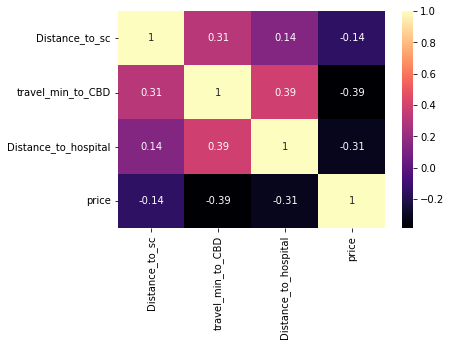

In [17]:
#Plot heatmap of correlation between columns
sns.heatmap(df[columns].corr(),annot=True,cmap='magma')

Text(0.5, 0.98, 'Histograms for all attribute in the dataset. Data are raw (without any processing).')

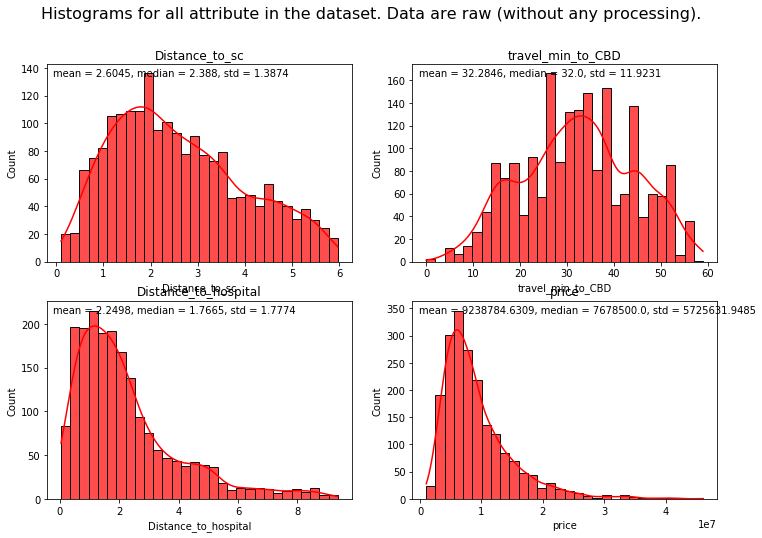

In [18]:
#Histogram and Normality
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(2, 2, figsize=(12,8))
#Set attribute iterator to 0
tau = 0
#Iterate over all dataframe attributes and plot
for i in [0,1]:
    for j in [0,1]:
        data_plot = df[columns[tau]]     #data to plot
        sns.histplot(data_plot, color="r", bins=30, alpha=0.7, kde=True, ax=axs[i,j]).set(title=columns[tau])
        statis = norm.fit(data_plot)
        mean = round(statis[0],4)                   #Calculate mean
        std = round(statis[1],4)                    #Calculate standard deviation
        median = round(np.median(data_plot),4)     #Calculate median
        #Add mean, median, and standard deviation to the plot
        axs[i,j].text(0.02, 0.98, f"mean = {mean}, median = {median}, std = {std}", ha="left", va="top", transform=axs[i,j].transAxes)
        tau += 1
#Add title
fig.suptitle("Histograms for all attribute in the dataset. Data are raw (without any processing).", fontsize = 16)  

Text(0.5, 0.98, 'Q-Q plots for all attribute in the dataset. Data are raw (without any processing).')

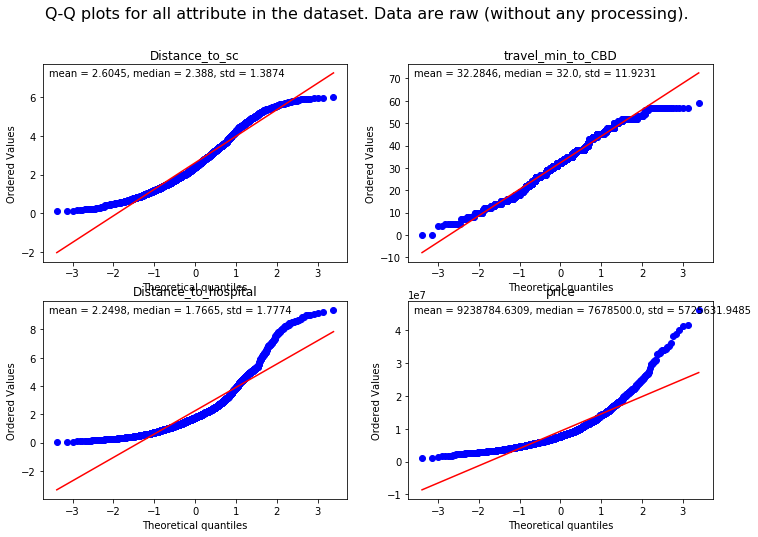

In [19]:
#QQ plot and Normality
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(2, 2, figsize=(12,8))
#Set attribute iterator to 0
tau = 0
#Iterate over all dataframe attributes and plot
for i in [0,1]:
    for j in [0,1]:                     
        data_plot = df[columns[tau]]   #Data to plot
        stats.probplot(data_plot, dist="norm", plot=axs[i,j])         
        #sm.qqplot(data_plot, stats.t, fit=True, line="45")  
        statis = norm.fit(data_plot)
        mean = round(statis[0],4)                   #Calculate mean
        std = round(statis[1],4)                    #Calculate standard deviation
        median = round(np.median(data_plot),4)     #Calculate median
        #Add mean, median, and standard deviation to the plot
        axs[i,j].text(0.02, 0.98, f"mean = {mean}, median = {median}, std = {std}", ha="left", va="top", transform=axs[i,j].transAxes)
        axs[i,j].set_title(columns[tau])
        tau += 1
#Add title
fig.suptitle("Q-Q plots for all attribute in the dataset. Data are raw (without any processing).", fontsize = 16)     

Text(0.5, 0.98, 'Boxplots for all attribute in the dataset. Data are raw (without any processing).')

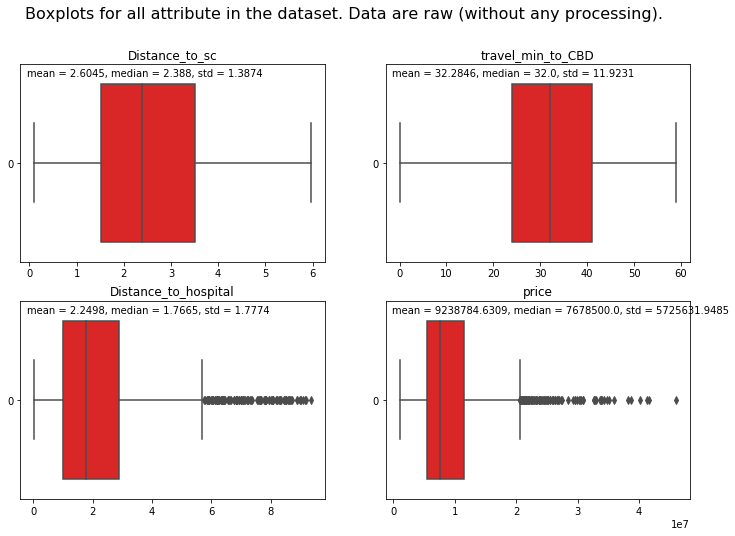

In [20]:
#Boxplot and Normality
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(2, 2, figsize=(12,8))
#Set attribute iterator to 0
tau = 0
#Iterate over all dataframe attributes and plot
for i in [0,1]:
    for j in [0,1]:
        data_plot = df[columns[tau]]
        sns.boxplot(data=data_plot, orient="h", color="r", saturation=0.7, ax=axs[i,j]).set(title=columns[tau])
        statis = norm.fit(data_plot)
        mean = round(statis[0],4)                   #Calculate mean
        std = round(statis[1],4)                    #Calculate standard deviation
        median = round(np.median(data_plot),4)     #Calculate median
        #Add mean, median, and standard deviation to the plot
        axs[i,j].text(0.02, 0.98, f"mean = {mean}, median = {median}, std = {std}", ha="left", va="top", transform=axs[i,j].transAxes)
        tau += 1
#Add title
fig.suptitle("Boxplots for all attribute in the dataset. Data are raw (without any processing).", fontsize = 16)     

Text(0.5, 0.98, 'Scatterplots for price vs. other attribute in the dataset. Data are raw (without any processing).')

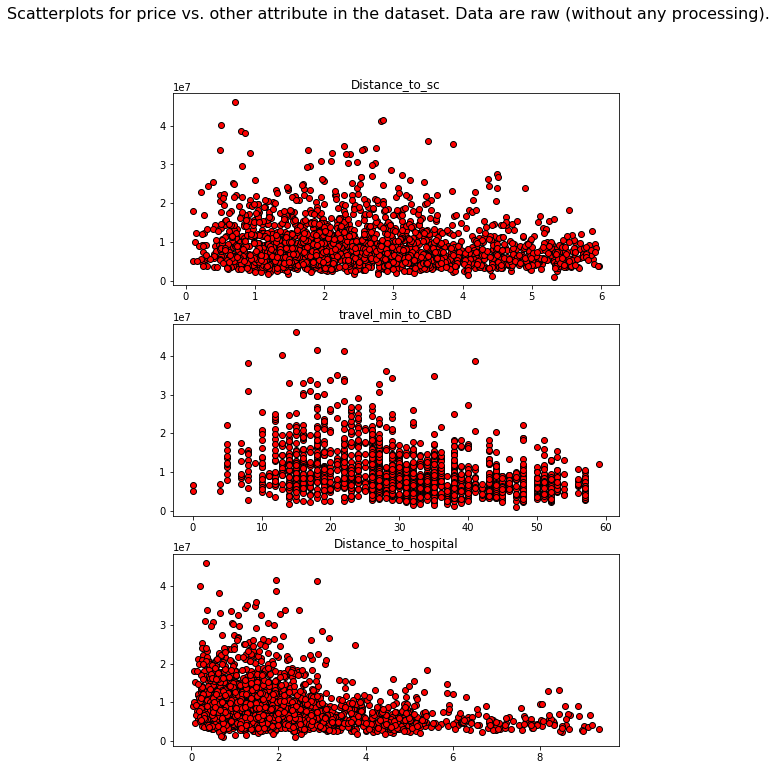

In [21]:
#Scatter plot and linearity
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(3, 1, figsize=(8,12))
#Set attribute iterator to 0
tau = 0
#Iterate over all dataframe attributes and plot
for tau in [0,1,2]:
    data_plot = df[columns[tau]]
    axs[tau].plot(data_plot, df["price"], 'o', c="k", markersize=6, 
                 linewidth=2, markerfacecolor="r", markeredgecolor='k', markeredgewidth=1, label=columns[tau])
    statis = norm.fit(data_plot)
    mean = round(statis[0],4)            #Calculate mean
    std = round(statis[1],4)             #Calculate standard deviation
    median = round(np.median(data_plot),4)     #Calculate median
    #Add mean, median, and standard deviation to the plot
    axs[tau].set_title(columns[tau])
#Add title
fig.suptitle("Scatterplots for price vs. other attribute in the dataset. Data are raw (without any processing).", fontsize = 16)     

Based on the above graphs, some EDA insights we can extract are as follows:
* Heatmap and correlaton calculations show that there is no particular correlation between independent variables, which is good.
* `Distance_to_sc`, `Distance_to_hospital`, and `price` show slight positive skewness.
* The majority of the data points are not located on the straight diagonal x-y line in the Q-Q plot, indicating lack of normality. A bow-shaped pattern of deviations from the diagonal indicates excessive skewness. On the other hand, an S-shaped pattern of deviations implies large kurtosis.
* Boxplot demonstrates presence of outliers in some of the variables. 
* Scatter plot demonstrates lack of linear relationship between independent variables and dependent variable.
* `travel_min_to_CBD` shows some negative skewness (left-skewed). However, the non-normality for this attribute is small compared to other attributes, as most data points fall almost perfectly on the straight line in Q-Q plot.

We can see that most of the data are characterised by non-normality and non-linearity.

#### Linear Regression and Plotting Residuals of Raw Data

In order to perform EDA on the residuals, we need to build linera regression model and then do predictions. 

In [22]:
#Define build_lrmod function 
def build_lrmod(dataframe, col_names, suffix):
    X = dataframe.loc[:, col_names[:3]]                               #Independent variables
    y = dataframe.loc[:, col_names[3]]                                #Dependent variable

    lm = linear_model.LinearRegression()                              #Create an instance of linear model
    model = lm.fit(X, y)                                              #Fit the model to data
    score = model.score(X,y)                                          #Get R2 for model
    coeffs = model.coef_                                              #Get coefficients of the parameters
    intercept = model.intercept_                                      #Get intercept of the model

    #Define new column names
    pred_col_name = "predictions" + "_" + str(suffix)       
    residual_col_name = "resid" + "_" + str(suffix)
    residual_norm_col_name = "resid_norm" + "_" + str(suffix)
    #Do predictions for testing (produces an array)
    predictions = model.predict(X)
    dataframe.loc[:,pred_col_name] = predictions                 #Add predictions as another column to dataframe
    dataframe.loc[:,residual_col_name] = dataframe.loc[:,pred_col_name] - dataframe.loc[:,col_names[3]]   #Compute residuals

    #st_dev = np.std(df_season_pred["resid"])
    #mean = np.mean(df_season_pred["resid"])
    #n = len(df_season_pred["resid"])
    mean = dataframe[residual_col_name].mean()
    st_dev = dataframe[residual_col_name].std(ddof=0)
    
    #Calculate Z-score and add as a separate column
    dataframe.loc[:,residual_norm_col_name] = (dataframe.loc[:,residual_col_name] - mean)/st_dev       

    print (f'########## Results of Linear Regression Modelling ########## \n')
    print (f'Score (the coefficient of determination R^2) of the model: {round(score, 4)}')
    print (f'Intercept in the model: {round(intercept,4)}')
    print (f'Standard deviation of the residuals: {round(st_dev,4)}')
    print (f'Mean of the residuals: {round(mean,4)}')
    print (f'Model coefficients:')
    coeffs_df = pd.DataFrame(np.round(coeffs,5), X.columns, columns=['Coefficient'])        #Put coeffs in a dataframe
    print (coeffs_df, "\n")
    
    return dataframe                                                            #Return the new dataframe

In [23]:
#Build a linear regression model, add residuals and predictions, and show the results and characteristics
df_LR = build_lrmod(df, columns, "raw")

########## Results of Linear Regression Modelling ########## 

Score (the coefficient of determination R^2) of the model: 0.1801
Intercept in the model: 15581740.0028
Standard deviation of the residuals: 5184496.7858
Mean of the residuals: 0.0
Model coefficients:
                       Coefficient
Distance_to_sc        -91101.69788
travel_min_to_CBD    -146570.67775
Distance_to_hospital -610577.08679 



C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Text(0.5, 0.98, 'Visualisation of residuals. Plots are related to raw data (without any processing).')

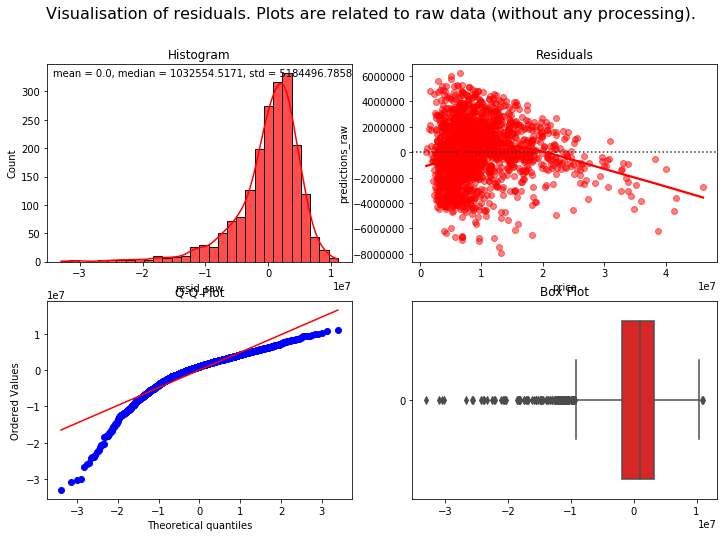

In [24]:
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(2, 2, figsize=(12,8))

data_plot = df_LR["resid_raw"]     #data to plot
statis = norm.fit(data_plot)                #Fit normal distribution
mean = round(statis[0],4)                   #Calculate mean
std = round(statis[1],4)                    #Calculate standard deviation
median = round(np.median(data_plot),4)     #Calculate median

#Plot histogram
sns.histplot(data_plot, color="r", bins=30, alpha=0.7, kde=True, ax=axs[0,0]).set(title="Histogram")
#Add mean, median, and standard deviation to the plot
axs[0,0].text(0.02, 0.98, f"mean = {mean}, median = {median}, std = {std}", ha="left", va="top", transform=axs[0,0].transAxes)

#Plot residual plot
sns.residplot(x="price", y="predictions_raw", data=df_LR, 
                      lowess=True, color="r", scatter_kws={'alpha':0.5}, ax=axs[0,1]).set(title="Residuals")
#Plot Q-Q plot
stats.probplot(data_plot, dist="norm", plot=axs[1,0]) 
axs[1,0].set_title("Q-Q Plot")

#Plot boxplot
sns.boxplot(data=data_plot, orient="h", color="r", saturation=0.7, ax=axs[1,1]).set(title="Box Plot")

#Add title
fig.suptitle("Visualisation of residuals. Plots are related to raw data (without any processing).", fontsize = 16)     

The EDA on residuals shows that they are left-skewed together with having large number of outliers. Scatter plot of the residuals also shows an uneven distribution together with a pattern. Q-Q plot shows lack of normality, as data points did not fall on the line. Overall, residuals exhibit lack of normality.

### Data Transformations

In this section, we apply transformation on the variables to reach normality and linearity. From the results of EDA, we can try out `log` or `sqrt` transformations. `Box-Cox` transformation might come in handy as well.

In [25]:
#Apply transformation on variables
df_LR.loc[:,"Distance_to_sc_trans"] = stats.boxcox(df_LR.loc[:,"Distance_to_sc"])[0]
df_LR.loc[:,"travel_min_to_CBD_trans"] = np.power(df_LR.loc[:,"travel_min_to_CBD"],1)
df_LR.loc[:,"Distance_to_hospital_trans"] = stats.boxcox(df_LR.loc[:,"Distance_to_hospital"])[0]
df_LR.loc[:,"price_trans"] = stats.boxcox(df_LR.loc[:,"price"])[0]

#Collect transformed column names for later analysis
columns_trans = [(col+"_trans") for col in columns]

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


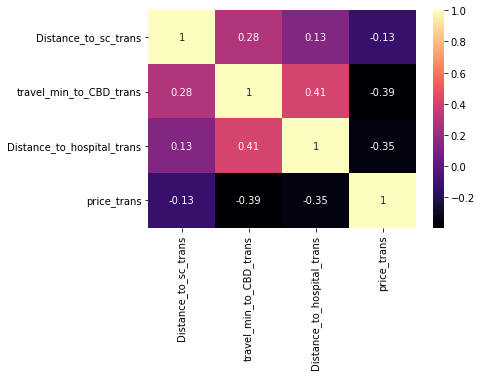

In [26]:
#Plot heatmap of correlation between columns
sns.heatmap(df_LR[columns_trans].corr(), annot=True, cmap='magma')

Text(0.5, 0.98, 'Histograms for all attribute in the dataset. Plots are related to transformed variables.')

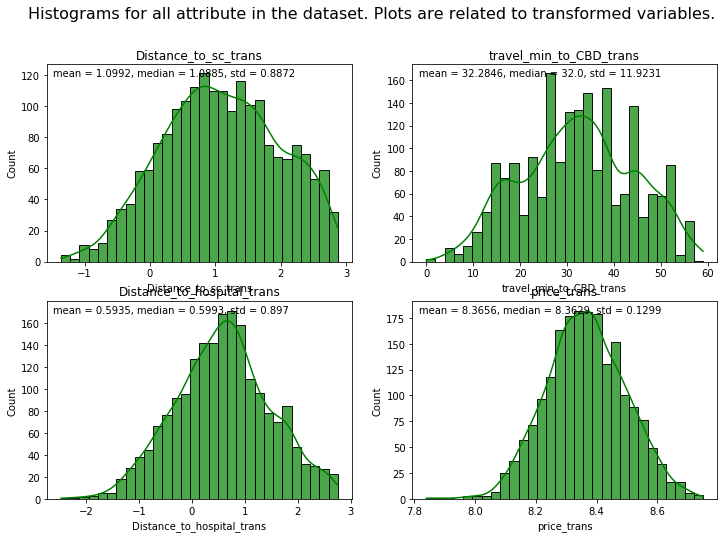

In [27]:
#Histograms and Normality
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(2, 2, figsize=(12,8))
#Set attribute iterator to 0
tau = 0            
#Iterate over all dataframe attributes and plot
for i in [0,1]:
    for j in [0,1]:
        data_plot = df_LR[(df_LR[columns_trans[tau]]>-np.inf) &
                                     (df_LR[columns_trans[tau]]<np.inf)][columns_trans[tau]]     #data to plot
        sns.histplot(data_plot, color="g", bins=30, alpha=0.7, kde=True, ax=axs[i,j]).set(title=columns_trans[tau])
        statis = norm.fit(data_plot)
        mean = round(statis[0],4)                   #Calculate mean
        std = round(statis[1],4)                    #Calculate standard deviation
        median = round(np.median(data_plot),4)     #Calculate median
        #Add mean, median, and standard deviation to the plot
        axs[i,j].text(0.02, 0.98, f"mean = {mean}, median = {median}, std = {std}", ha="left", va="top", transform=axs[i,j].transAxes)
        tau += 1
#Add title
fig.suptitle("Histograms for all attribute in the dataset. Plots are related to transformed variables.", fontsize = 16)     

Text(0.5, 0.98, 'Q-Q plots for all attribute in the dataset. Plots are related to transformed variables.')

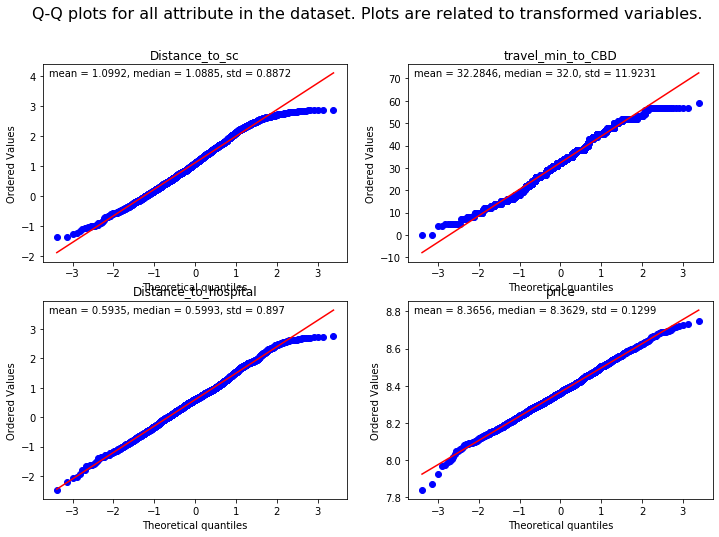

In [28]:
#QQplot and Normality
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(2, 2, figsize=(12,8))
#Set attribute iterator to 0
tau = 0
#Iterate over all dataframe attributes and plot
for i in [0,1]:
    for j in [0,1]:                     
        data_plot = df_LR[(df_LR[columns_trans[tau ]]>-np.inf) &
                                     (df_LR[columns_trans[tau ]]<np.inf)][columns_trans[tau ]]     #data to plot
        stats.probplot(data_plot, dist="norm", plot=axs[i,j])         
        #sm.qqplot(data_plot, stats.t, fit=True, line="45")  
        statis = norm.fit(data_plot)
        mean = round(statis[0],4)                   #Calculate mean
        std = round(statis[1],4)                    #Calculate standard deviation
        median = round(np.median(data_plot),4)     #Calculate median
        #Add mean, median, and standard deviation to the plot
        axs[i,j].text(0.02, 0.98, f"mean = {mean}, median = {median}, std = {std}", ha="left", va="top", transform=axs[i,j].transAxes)
        axs[i,j].set_title(columns[tau ])
        tau  += 1
#Add title
fig.suptitle("Q-Q plots for all attribute in the dataset. Plots are related to transformed variables.", fontsize = 16)     

Text(0.5, 0.98, 'Boxplots for all attribute in the dataset. Plots are related to transformed variables.')

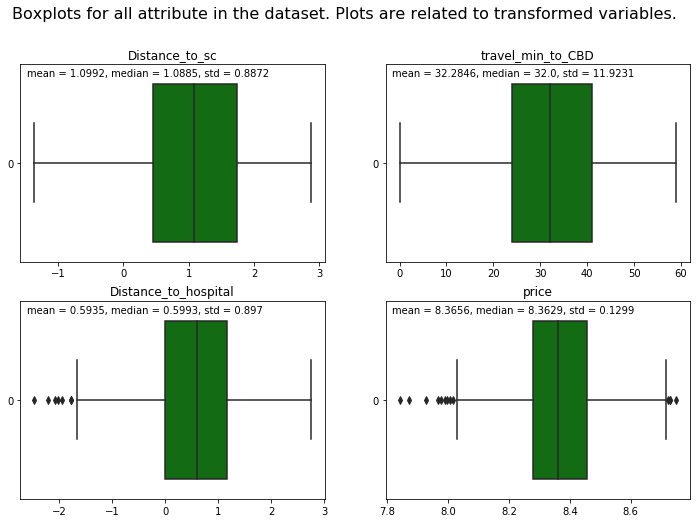

In [29]:
#Boxplot and Normality
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(2, 2, figsize=(12,8))
#Set attribute iterator to 0
tau = 0
#Iterate over all dataframe attributes and plot
for i in [0,1]:
    for j in [0,1]:
        data_plot = df_LR[(df_LR[columns_trans[tau]]>-np.inf) &
                                     (df_LR[columns_trans[tau]]<np.inf)][columns_trans[tau]]     #data to plot
        sns.boxplot(data=data_plot, orient="h", color="g", saturation=0.7, ax=axs[i,j]).set(title=columns[tau])
        statis = norm.fit(data_plot)
        mean = round(statis[0],4)                   #Calculate mean
        std = round(statis[1],4)                    #Calculate standard deviation
        median = round(np.median(data_plot),4)     #Calculate median
        #Add mean, median, and standard deviation to the plot
        axs[i,j].text(0.02, 0.98, f"mean = {mean}, median = {median}, std = {std}", ha="left", va="top", transform=axs[i,j].transAxes)
        tau += 1
#Add title
fig.suptitle("Boxplots for all attribute in the dataset. Plots are related to transformed variables.", fontsize = 16)     

Text(0.5, 0.98, 'Scatterplots for price vs. other attribute in the dataset. Plots are related to transformed variables.')

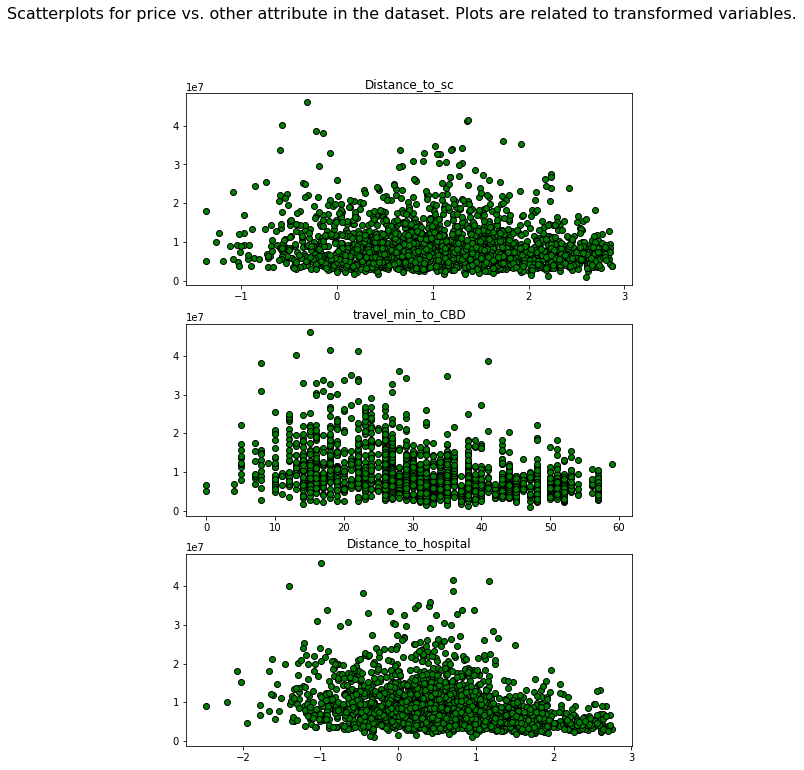

In [30]:
#Scatterplot and Linearity
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(3, 1, figsize=(8,12))
#Set attribute iterator to 0
tau = 0
#Iterate over all dataframe attributes and plot
for tau in [0,1,2]:
    data_plot = df_LR[(df_LR[columns_trans[tau]]>-np.inf) &
                                     (df_LR[columns_trans[tau]]<np.inf)][columns_trans[tau]]     #data to plot
    axs[tau].plot(data_plot, df_LR["price"], 'o', c="k", markersize=6, 
                 linewidth=2, markerfacecolor="g", markeredgecolor='k', markeredgewidth=1, label=columns[tau])
    statis = norm.fit(data_plot)
    mean = round(statis[0],4)            #Calculate mean
    std = round(statis[1],4)             #Calculate standard deviation
    median = round(np.median(data_plot),4)     #Calculate median
    #Add mean, median, and standard deviation to the plot
    axs[tau].set_title(columns[tau])
#Add title
fig.suptitle("Scatterplots for price vs. other attribute in the dataset. Plots are related to transformed variables.", fontsize = 16)     

From the above graphs, some EDA insights are as follows: 
* Heatmap and correlaton show that there is no particular correlation between independent variables, which is good.
* Application of `Box-Cox` transformation resulted in significant improvement in the normality of the variables `Distance_to_sc`, `Distance_to_hospital`, and `price`,as Skewness problem is resolved greatly.
* Q-Q plots show the majority of the data points now fall on the straight diagonal x-y line, indicating normality.
* Boxplot demonstrates that most of the data points that were recognised as outliers are no more outliers.
* Scatter plot demonstrates linear relationship between independent variables and dependent variable.

We can see that the problems with normality and lineary have remarkably been resolved by applying `Box-Cox` transformation.

#### Linear Regression and Plotting Residuals of the Transformed Data

In [31]:
#Build a linear regression model, add residuals and predictions, and show the results and characteristics
df_LR = build_lrmod(df_LR, columns_trans, "trans")

########## Results of Linear Regression Modelling ########## 

Score (the coefficient of determination R^2) of the model: 0.1998
Intercept in the model: 8.4924
Standard deviation of the residuals: 0.1162
Mean of the residuals: -0.0
Model coefficients:
                            Coefficient
Distance_to_sc_trans           -0.00285
travel_min_to_CBD_trans        -0.00322
Distance_to_hospital_trans     -0.03305 



C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Text(0.5, 0.98, 'Visualisation of residuals. Plots are related to transformed variables.')

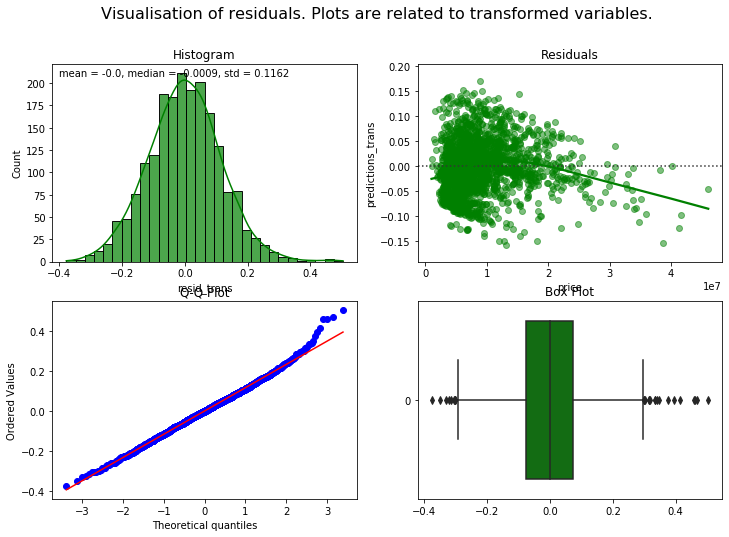

In [32]:
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(2, 2, figsize=(12,8))

data_plot = df_LR["resid_trans"]     #data to plot
statis = norm.fit(data_plot)                #Fit normal distribution
mean = round(statis[0],4)                   #Calculate mean
std = round(statis[1],4)                    #Calculate standard deviation
median = round(np.median(data_plot),4)     #Calculate median

#Plot histogram
sns.histplot(data_plot, color="g", bins=30, alpha=0.7, kde=True, ax=axs[0,0]).set(title="Histogram")
#Add mean, median, and standard deviation to the plot
axs[0,0].text(0.02, 0.98, f"mean = {mean}, median = {median}, std = {std}", ha="left", va="top", transform=axs[0,0].transAxes)

#Plot residual plot
sns.residplot(x="price", y="predictions_trans", data=df_LR, 
                      lowess=True, color="g", scatter_kws={'alpha':0.5}, ax=axs[0,1]).set(title="Residuals")
#Plot Q-Q plot
stats.probplot(data_plot, dist="norm", plot=axs[1,0]) 
axs[1,0].set_title("Q-Q Plot")

#Plot boxplot
sns.boxplot(data=data_plot, orient="h", color="g", saturation=0.7, ax=axs[1,1]).set(title="Box Plot")

#Add title
fig.suptitle("Visualisation of residuals. Plots are related to transformed variables.", fontsize = 16)     

The EDA on residuals for transformed data shows that applying `Box-Cox` transformation on the raw data resolved the problem with normality of residuals and now they are normally distributed. Scatter plot of the residuals also shows improvement in distribution. Q-Q plot shows great improvement in normality, as nearly all data points now fall on the diagonal line. Finally, the number of outliers in the boxplot greatly decreased. Overall, the problem of normality is now resolved.

With respect to the linear regression model, it showed that price of the house has negative correlation with the three independent variable. That is, with increase in distance to hospital or shopping center or increase in travel time to CBD, the price of the house reduces.

### Data Scaling

Data Scaling can be used in Linear regression, to improve interpretability. 

In [33]:
df_LR[columns_trans].describe()

,Distance_to_sc_trans,travel_min_to_CBD_trans,Distance_to_hospital_trans,price_trans
count,1978.000000,1978.000000,1978.000000,1978.000000
mean,1.099181,32.284631,0.593492,8.365600
std,0.887384,11.926108,0.897221,0.129976
min,-1.360390,0.000000,-2.469268,7.840438
25%,0.456614,24.000000,-0.005010,8.280127
50%,1.088454,32.000000,0.599277,8.362882
75%,1.745272,41.000000,1.170039,8.455447
max,2.872457,59.000000,2.755033,8.749758


There are various scaling methods. In this part, I will try out 2 methods: `MinMax Scaler` and `Standard Scaler`

In [34]:
#Initiate an instance of scaler
scaler = MinMaxScaler() 

#Apply scaling on variables
df_LR["Distance_to_sc_scaled"] = scaler.fit_transform(df_LR.loc[:,"Distance_to_sc_trans"].values.reshape(-1, 1))
df_LR["travel_min_to_CBD_scaled"] = scaler.fit_transform(df_LR.loc[:,"travel_min_to_CBD_trans"].values.reshape(-1, 1))
df_LR["Distance_to_hospital_scaled"] = scaler.fit_transform(df_LR.loc[:,"Distance_to_hospital_trans"].values.reshape(-1, 1))
df_LR["price_scaled"] = scaler.fit_transform(df_LR.loc[:,"price_trans"].values.reshape(-1, 1))

#Collect transformed column names for later analysis
columns_scaled = [(col+"_scaled") for col in columns]

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

`MinMaxScaler()` changes all the values in each variable to a range between 0 and 1. In the next step, we perform EDA on the new scaled variables. We also fit a new linear regression model to the scaled data and examine the model.

Text(0.5, 0.98, 'Histograms for all attribute in the dataset. Plots are related to scaled variables.')

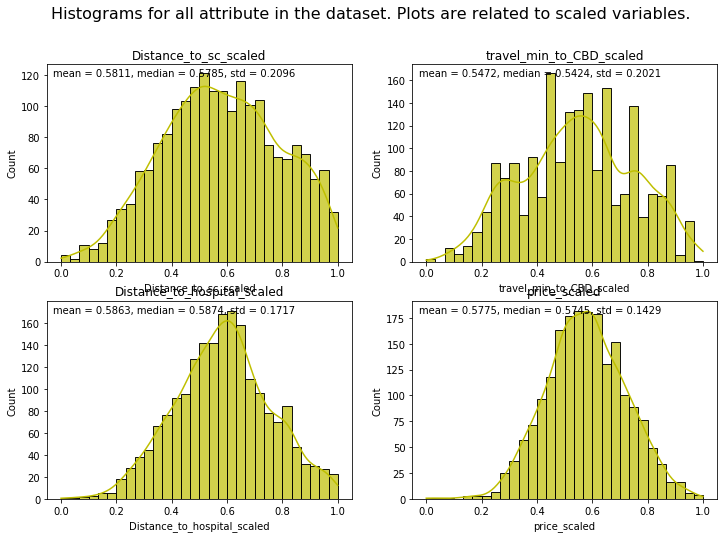

In [35]:
#Histograms and Normality
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(2, 2, figsize=(12,8))
#Set attribute iterator to 0
tau = 0            
#Iterate over all dataframe attributes and plot
for i in [0,1]:
    for j in [0,1]:
        data_plot = df_LR[(df_LR[columns_scaled[tau]]>-np.inf) &
                                     (df_LR[columns_scaled[tau]]<np.inf)][columns_scaled[tau]]     #data to plot
        sns.histplot(data_plot, color="y", bins=30, alpha=0.7, kde=True, ax=axs[i,j]).set(title=columns_scaled[tau])
        statis = norm.fit(data_plot)
        mean = round(statis[0],4)                   #Calculate mean
        std = round(statis[1],4)                    #Calculate standard deviation
        median = round(np.median(data_plot),4)     #Calculate median
        #Add mean, median, and standard deviation to the plot
        axs[i,j].text(0.02, 0.98, f"mean = {mean}, median = {median}, std = {std}", ha="left", va="top", transform=axs[i,j].transAxes)
        tau += 1
#Add title
fig.suptitle("Histograms for all attribute in the dataset. Plots are related to scaled variables.", fontsize = 16)     

Text(0.5, 0.98, 'Q-Q plots for all attribute in the dataset. Plots are related to scaled variables.')

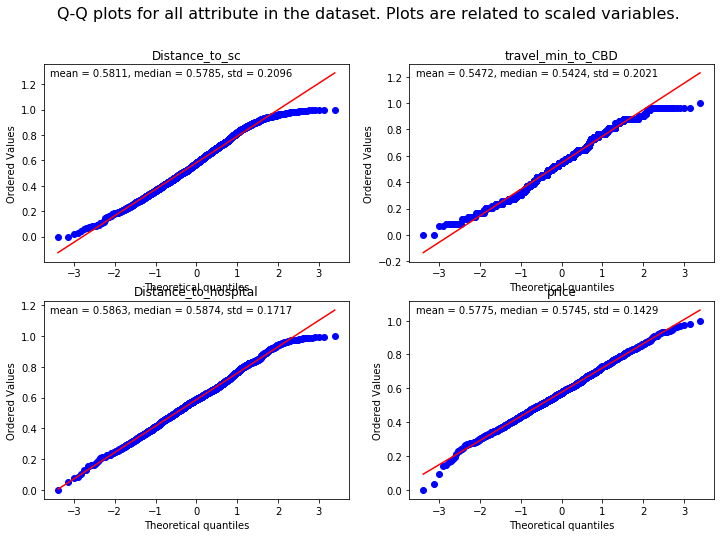

In [37]:
#QQplot and Normality
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(2, 2, figsize=(12,8))
#Set attribute iterator to 0
tau = 0
#Iterate over all dataframe attributes and plot
for i in [0,1]:
    for j in [0,1]:                     
        data_plot = df_LR[(df_LR[columns_scaled[tau]]>-np.inf) &
                                     (df_LR[columns_scaled[tau]]<np.inf)][columns_scaled[tau]]     #data to plot
        stats.probplot(data_plot, dist="norm", plot=axs[i,j])         
        #sm.qqplot(data_plot, stats.t, fit=True, line="45")  
        statis = norm.fit(data_plot)
        mean = round(statis[0],4)                   #Calculate mean
        std = round(statis[1],4)                    #Calculate standard deviation
        median = round(np.median(data_plot),4)     #Calculate median
        #Add mean, median, and standard deviation to the plot
        axs[i,j].text(0.02, 0.98, f"mean = {mean}, median = {median}, std = {std}", ha="left", va="top", transform=axs[i,j].transAxes)
        axs[i,j].set_title(columns[tau])
        tau += 1
#Add title
fig.suptitle("Q-Q plots for all attribute in the dataset. Plots are related to scaled variables.", fontsize = 16)     

Text(0.5, 0.98, 'Boxplots for all attribute in the dataset. Plots are related to scaled variables.')

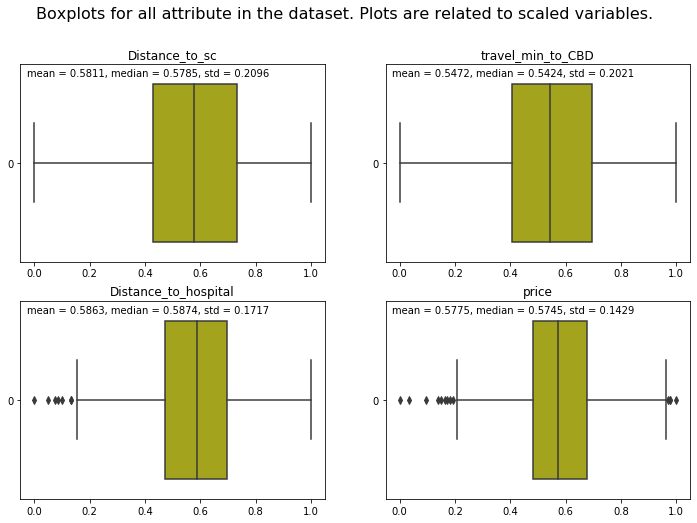

In [38]:
#Boxplot and Normality
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(2, 2, figsize=(12,8))
#Set attribute iterator to 0
tau = 0
#Iterate over all dataframe attributes and plot
for i in [0,1]:
    for j in [0,1]:
        data_plot = df_LR[(df_LR[columns_scaled[tau]]>-np.inf) &
                                     (df_LR[columns_scaled[tau]]<np.inf)][columns_scaled[tau]]     #data to plot
        sns.boxplot(data=data_plot, orient="h", color="y", saturation=0.7, ax=axs[i,j]).set(title=columns[tau])
        statis = norm.fit(data_plot)
        mean = round(statis[0],4)                   #Calculate mean
        std = round(statis[1],4)                    #Calculate standard deviation
        median = round(np.median(data_plot),4)     #Calculate median
        #Add mean, median, and standard deviation to the plot
        axs[i,j].text(0.02, 0.98, f"mean = {mean}, median = {median}, std = {std}", ha="left", va="top", transform=axs[i,j].transAxes)
        tau += 1
#Add title
fig.suptitle("Boxplots for all attribute in the dataset. Plots are related to scaled variables.", fontsize = 16)     

Text(0.5, 0.98, 'Scatterplots for price vs. other attribute in the dataset. Plots are related to scaled variables.')

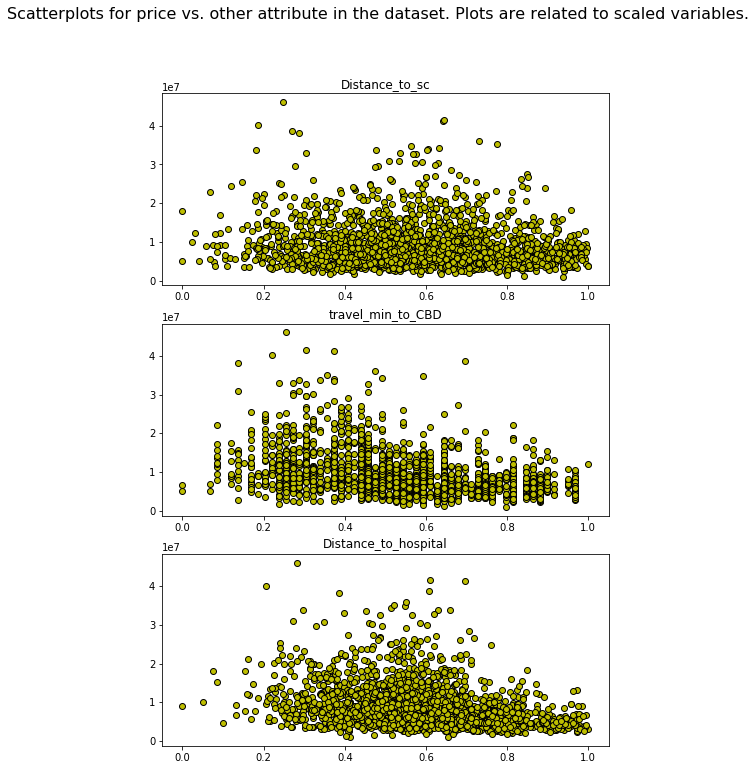

In [39]:
#Scatterplot and Linearity
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(3, 1, figsize=(8,12))
#Set attribute iterator to 0
tau = 0
#Iterate over all dataframe attributes and plot
for tau in [0,1,2]:
    data_plot = df_LR[(df_LR[columns_scaled[tau]]>-np.inf) &
                                     (df_LR[columns_scaled[tau]]<np.inf)][columns_scaled[tau]]     #data to plot
    axs[tau].plot(data_plot, df_LR["price"], 'o', c="k", markersize=6, 
                 linewidth=2, markerfacecolor="y", markeredgecolor='k', markeredgewidth=1, label=columns[tau])
    statis = norm.fit(data_plot)
    mean = round(statis[0],4)            #Calculate mean
    std = round(statis[1],4)             #Calculate standard deviation
    median = round(np.median(data_plot),4)     #Calculate median
    #Add mean, median, and standard deviation to the plot
    axs[tau].set_title(columns[tau])
#Add title
fig.suptitle("Scatterplots for price vs. other attribute in the dataset. Plots are related to scaled variables.", fontsize = 16)     

As the plotting and EDA above showed, there is no change in the overall format of the plots. That is, the distribution, normality, linearity, and outliers are all the same. However, the range and scale of the data changed, which was expected.

#### Linear Regression and Plotting Residuals of the Scaled Data

In [40]:
#Build a linear regression model, add residuals and predictions, and show the results and characteristics
df_LR = build_lrmod(df_LR, columns_scaled, "scaled")

########## Results of Linear Regression Modelling ########## 

Score (the coefficient of determination R^2) of the model: 0.1998
Intercept in the model: 0.811
Standard deviation of the residuals: 0.1278
Mean of the residuals: 0.0
Model coefficients:
                             Coefficient
Distance_to_sc_scaled           -0.01328
travel_min_to_CBD_scaled        -0.20911
Distance_to_hospital_scaled     -0.18990 



C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Text(0.5, 0.98, 'Visualisation of residuals. Plots are related to scaled variables.')

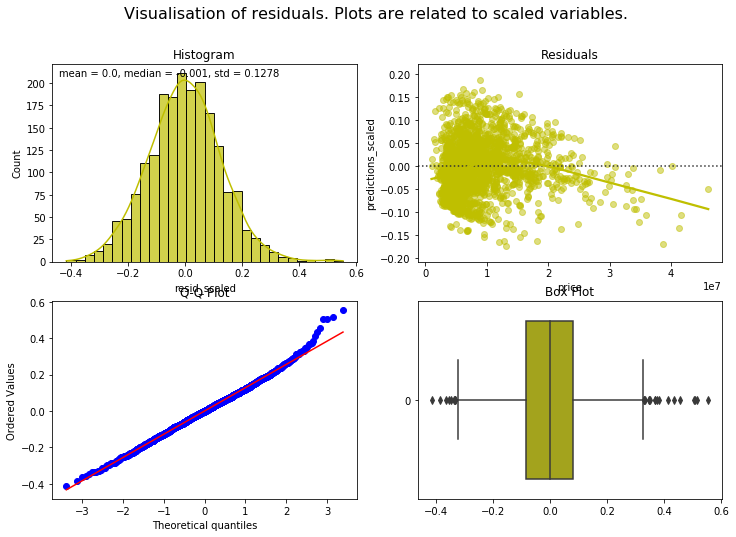

In [41]:
#Prepare an instance of figure and axes and subplotting
fig, (axs) = plt.subplots(2, 2, figsize=(12,8))

data_plot = df_LR["resid_scaled"]     #data to plot
statis = norm.fit(data_plot)                #Fit normal distribution
mean = round(statis[0],4)                   #Calculate mean
std = round(statis[1],4)                    #Calculate standard deviation
median = round(np.median(data_plot),4)     #Calculate median

#Plot histogram
sns.histplot(data_plot, color="y", bins=30, alpha=0.7, kde=True, ax=axs[0,0]).set(title="Histogram")
#Add mean, median, and standard deviation to the plot
axs[0,0].text(0.02, 0.98, f"mean = {mean}, median = {median}, std = {std}", ha="left", va="top", transform=axs[0,0].transAxes)

#Plot residual plot
sns.residplot(x="price", y="predictions_scaled", data=df_LR, 
                      lowess=True, color="y", scatter_kws={'alpha':0.5}, ax=axs[0,1]).set(title="Residuals")
#Plot Q-Q plot
stats.probplot(data_plot, dist="norm", plot=axs[1,0]) 
axs[1,0].set_title("Q-Q Plot")

#Plot boxplot
sns.boxplot(data=data_plot, orient="h", color="y", saturation=0.7, ax=axs[1,1]).set(title="Box Plot")

#Add title
fig.suptitle("Visualisation of residuals. Plots are related to scaled variables.", fontsize = 16)     

EDA showed no particular change in the format of the residuals.

* The coefficients of the model increased in magnitude proportionally. This is clearly due to the scaling of the magnitude of the variables. 
* The price of the house has negative correlation with the three independent variable. Increase in the value of the three independent variable causes decrease in the price of the house.
* The order of effectiveness of the variables in determining the price of the house is: `Distance_to_hospital` > `travel_min_to_CBD` > `Distance_to_sc`.